In [1]:
import illustris_python as il
import numpy as np
from astropy.table import *
import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree
import matplotlib 
from statsmodels.nonparametric.smoothers_lowess import lowess
import os
import seaborn as sns
from tqdm import tqdm
from datetime import datetime

matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['xtick.labelsize'] = 13
matplotlib.rcParams['ytick.labelsize'] = 13

### set binning

In [3]:
bin_number = 14
bin_edges = 10 ** np.linspace(1.0, 2.845, num=bin_number + 1)

areas = np.array([])
for i in range(len(bin_edges[:-1])):
    areas = np.append(areas, (bin_edges[i + 1] ** 2 - bin_edges[i] ** 2) * np.pi)

### projected profiles

In [4]:
# half mass radius definition: ['SubhaloMassInRadType'][:,4]
# surface magnitude definition: ['SubhaloStellarPhotometricsMassInRad']

def radial(massive_central_halos,subhalos,z,sat_cut_low,sat_cut_high, ssfq='all', proj_collapse=0):
    proj = np.delete(np.array([0,1,2]),proj_collapse)
    subhalos['SubhaloSFR'][subhalos['SubhaloSFR']==0.0] = 1e-10
    
    # cosmological scale factor
    a=1/(1+z)
    sat_masscut = 10**(sat_cut_low-10)
    sat_masscut_high = 10**(sat_cut_high-10)

    # satellite galaxy mass cut logM=9.5
    subhalos_masscut = subhalos[subhalos['SubhaloStellarPhotometricsMassInRad']>sat_masscut*0.704]  # x*10^10 M_sun / h
    subhalos_masscut = subhalos_masscut[subhalos_masscut['SubhaloStellarPhotometricsMassInRad']<sat_masscut_high*0.704]
    
    tree = KDTree(subhalos_masscut['SubhaloPos'])
    tree_2d = KDTree(subhalos_masscut['SubhaloPos'][:,proj])

    radial_tot = np.zeros(bin_number)
    massive_count = 0
    for i in tqdm(range(len(massive_central_halos))):
        # find the subhalo that host central galaxy
        halo = massive_central_halos[i]
        first_subhalo = subhalos[halo['GroupFirstSub']]
    
        # cylinder shape selection
        ind = tree_2d.query_radius([halo['GroupPos'][proj]],bin_edges[-1]/a*0.704,count_only=False) # comoving kpc / h
        cat_neighbors = subhalos_masscut[ind[0]]
        cat_neighbors = cat_neighbors[abs(cat_neighbors['SubhaloPos'][:,proj_collapse]-halo['GroupPos'][proj_collapse])<bin_edges[-1]*1*0.704]
    
        # isolation criteria
        cat_massive_neighbors = cat_neighbors[cat_neighbors['SubhaloStellarPhotometricsMassInRad']>first_subhalo['SubhaloStellarPhotometricsMassInRad']]
        if len(cat_massive_neighbors)>=2:
            continue
        elif len(cat_neighbors)==0:
            continue 
    
        # do the measurement
        radial = []    
        log_ssfr_sats = np.log10(cat_neighbors['SubhaloSFR']/1e10/0.704/cat_neighbors['SubhaloStellarPhotometricsMassInRad'])
        if ssfq == 'ssf':
            cat_neighbors = cat_neighbors[log_ssfr_sats>-11]
        elif ssfq == 'sq':
            cat_neighbors = cat_neighbors[log_ssfr_sats<-11]
        else:
            pass
        
        if len(cat_neighbors)==0:
            continue
            
        subtree = KDTree(cat_neighbors['SubhaloPos'][:,proj])
        for bin_edge in bin_edges:
            ind = subtree.query_radius([halo['GroupPos'][proj]],bin_edge/a*0.704,count_only=True) # comoving kpc / h
            radial.append(ind[0])
        
        radial = np.diff(np.array(radial))
        radial_tot += radial
        massive_count += 1
    
    print('massive gals:',len(massive_central_halos),', isolated centrals:',massive_count)
    return radial_tot, np.sqrt(radial_tot), massive_count

def load_subhalo_halo(basePath, snap, cen_cut):
    header = il.groupcat.loadHeader(basePath,72)
    boxsize = header['BoxSize']
    central_masscut = 10**(cen_cut-10)
    print('start loading... mass cut = '+str(central_masscut))
    print(datetime.now())
    
    # load subhalos
    fields = ['SubhaloPos','SubhaloMass','SubhaloMassInRadType','SubhaloStellarPhotometrics','SubhaloSFR','SubhaloStellarPhotometricsMassInRad']
    subhalos = il.groupcat.loadSubhalos(basePath,snap,fields=fields)
    del subhalos['count']
    subhalos = Table(subhalos)
    print('load subhalos done, total number is ' + str(len(subhalos)))
    print(datetime.now())

    # load halos
    halos = il.groupcat.loadHalos(basePath,snap,fields=['GroupFirstSub','GroupPos','GroupMass'])
    del halos['count']
    halos = Table(halos)
    print('load Halos done, total number is ' + str(len(halos)))
    print(datetime.now())
    
    # cut massive central galaxies
    central_ids = halos['GroupFirstSub']
    halos = halos[central_ids<1000000000]
    central_ids = central_ids[central_ids<1000000000]
    first_subhalos = subhalos[central_ids]
    massive_central_halos = halos[first_subhalos['SubhaloStellarPhotometricsMassInRad']>central_masscut*0.704]
    print('halos with massive central: ',len(massive_central_halos))
    print(datetime.now())
    
    # cut off centrals that are close to edge
    mask = []
    for i in tqdm(range(len(massive_central_halos))):
        halo = massive_central_halos[i]
        central_on_edge = False
        for i in range(3):
            if abs(boxsize/2-subhalos[halo['GroupFirstSub']]['SubhaloPos'][i])>boxsize/2-bin_edges[-1]:
                central_on_edge = True
            
        if central_on_edge == True: 
            mask.append(False)
        else:
            mask.append(True)
    
    massive_central_halos = massive_central_halos[mask]
    print(datetime.now())
    return massive_central_halos, subhalos

In [10]:
path = 'sims.illustris/Illustris-1/output'
m_il,s_il=load_subhalo_halo(path,108,11.3)
path = 'sims.TNG/TNG300-1/output/'
m_tng,s_tng=load_subhalo_halo(path,72,11.3)

radial_il_tuple = radial(m_il,s_il,0.4,9.5,13.0)
radial_tng_tuple = radial(m_tng,s_tng,0.4,9.5,13.0)

np.save('radial_il_4_old.npy',np.asarray(radial_il_tuple))
np.save('radial_tng_4_old.npy' ,np.asarray(radial_tng_tuple))

load subhalos done
load Halos done
121


100%|██████████| 121/121 [00:00<00:00, 31681.80it/s]


load subhalos done
load Halos done
388


100%|██████████| 388/388 [00:00<00:00, 33361.14it/s]


In [34]:
# masscut for central galaxy
def mcen(z, cut_type='fixed'):
    if cut_type == 'moving':
        return 11.4-0.16*z
    else:
        return 11.3
#     return 11.15
#     return 11.41-0.4*z

# calculate and load in halos and subhalos
z=1.0
snap=50
mass_sat_low = 9.5
mass_sat_high = 12.0

m_tng,s_tng = load_subhalo_halo('sims.TNG/TNG300-1/output/',snap, mcen(z))
radial_tng_tuple = radial(m_tng,s_tng,z, mass_sat_low, mass_sat_high)
np.save('radial_tng_'+str(z)+'_'+str(mass_sat_low)+'_'+str(mass_sat_high)+'.npy', np.asarray(radial_tng_tuple))
print('saved')

# m_il2,s_il2=load_subhalo_halo('sims.TNG/TNG300-1/output/',63, mcen(0.6))
# m_il3,s_il3=load_subhalo_halo('sims.TNG/TNG300-1/output/',57, mcen(0.76))
# m_il4,s_il4=load_subhalo_halo('sims.TNG/TNG300-1/output/',50, mcen(1.00))

start loading... mass cut = 19.95262314968883
2021-10-25 18:09:32.754505
load subhalos done, total number is 17120875
2021-10-25 18:12:00.924574
load Halos done, total number is 19595267
2021-10-25 18:12:28.084244
halos with massive central:  171
2021-10-25 18:12:30.843318


100%|██████████| 171/171 [00:00<00:00, 31105.30it/s]

2021-10-25 18:12:30.854181



100%|██████████| 167/167 [00:00<00:00, 413.58it/s]

massive gals: 167 , isolated centrals: 167
saved



/opt/conda/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


#### test loading time

In [12]:
print(datetime.now())
fields = ['SubhaloPos','SubhaloMass','SubhaloMassInRadType','SubhaloStellarPhotometrics','SubhaloSFR','SubhaloStellarPhotometricsMassInRad']
subhalos = il.groupcat.loadSubhalos('sims.TNG/TNG300-1/output/',72,fields=fields)
print(datetime.now())

2021-10-11 20:31:59.586123
2021-10-11 20:34:37.614534


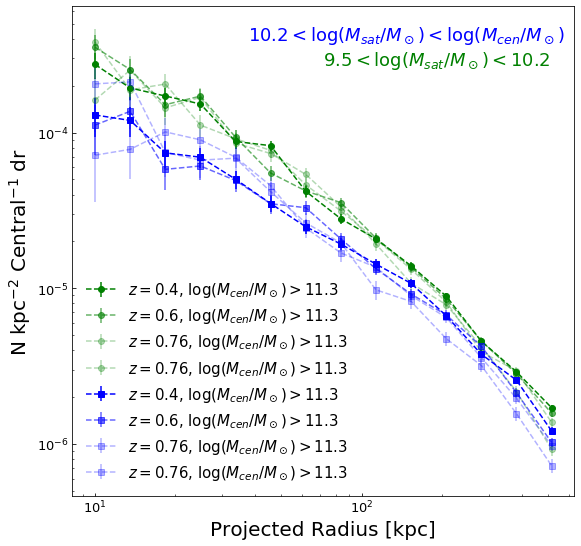

In [30]:
fig, axs = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(9, 9))

#### low mass ####
radial_tot_tng1, radial_tot_tng1_err, count_tng1 = np.load('radial_tng_0.4_9.5_10.2.npy',allow_pickle=True)
radial_tot_tng2, radial_tot_tng2_err, count_tng2 = np.load('radial_tng_0.6_9.5_10.2.npy',allow_pickle=True)
radial_tot_tng3, radial_tot_tng3_err, count_tng3 = np.load('radial_tng_0.76_9.5_10.2.npy',allow_pickle=True)
radial_tot_tng4, radial_tot_tng4_err, count_tng4 = np.load('radial_tng_1.0_9.5_10.2.npy',allow_pickle=True)

plt.errorbar(bin_edges[:-1],radial_tot_tng1/areas/count_tng1,yerr=radial_tot_tng1_err/areas/count_tng1,
             fmt='og--',label=r'$z=0.4$, $\log(M_{cen}/M_\odot)>$'+str(round(mcen(0.4),2)),alpha=1)
plt.errorbar(bin_edges[:-1],radial_tot_tng2/areas/count_tng2,yerr=radial_tot_tng2_err/areas/count_tng2,
             fmt='og--',label=r'$z=0.6$, $\log(M_{cen}/M_\odot)>$'+str(round(mcen(0.6),2)),alpha=0.6)
plt.errorbar(bin_edges[:-1],radial_tot_tng3/areas/count_tng3,yerr=radial_tot_tng3_err/areas/count_tng3,
             fmt='og--',label=r'$z=0.76$, $\log(M_{cen}/M_\odot)>$'+str(round(mcen(0.76),2)),alpha=0.3)
plt.errorbar(bin_edges[:-1],radial_tot_tng4/areas/count_tng4,yerr=radial_tot_tng4_err/areas/count_tng4,
             fmt='og--',label=r'$z=1.0$, $\log(M_{cen}/M_\odot)>$'+str(round(mcen(1.0),2)),alpha=0.3)

#### high mass ####
# mass_sat_low = 10.2
# mass_sat_high = 12.0

radial_tot_tng1, radial_tot_tng1_err, count_tng1 = np.load('radial_tng_0.4_10.2_12.0.npy',allow_pickle=True)
radial_tot_tng2, radial_tot_tng2_err, count_tng2 = np.load('radial_tng_0.6_10.2_12.0.npy',allow_pickle=True)
radial_tot_tng3, radial_tot_tng3_err, count_tng3 = np.load('radial_tng_0.76_10.2_12.0.npy',allow_pickle=True)
radial_tot_tng4, radial_tot_tng4_err, count_tng4 = np.load('radial_tng_1.0_10.2_12.0.npy',allow_pickle=True)

plt.errorbar(bin_edges[:-1],radial_tot_tng1/areas/count_tng1,yerr=radial_tot_tng1_err/areas/count_tng1,
             fmt='sb--',label=r'$z=0.4$, $\log(M_{cen}/M_\odot)>$'+str(round(mcen(0.4),2)),alpha=1)
plt.errorbar(bin_edges[:-1],radial_tot_tng2/areas/count_tng2,yerr=radial_tot_tng2_err/areas/count_tng2,
             fmt='sb--',label=r'$z=0.6$, $\log(M_{cen}/M_\odot)>$'+str(round(mcen(0.6),2)),alpha=0.6)
plt.errorbar(bin_edges[:-1],radial_tot_tng3/areas/count_tng3,yerr=radial_tot_tng3_err/areas/count_tng3,
             fmt='sb--',label=r'$z=0.76$, $\log(M_{cen}/M_\odot)>$'+str(round(mcen(0.76),2)),alpha=0.3)
plt.errorbar(bin_edges[:-1],radial_tot_tng4/areas/count_tng4,yerr=radial_tot_tng4_err/areas/count_tng4,
             fmt='sb--',label=r'$z=1.0$, $\log(M_{cen}/M_\odot)>$'+str(round(mcen(1.0),2)),alpha=0.3)
####
# plt.annotate(r'$z=$0.4',xy=([0.08,0.08]),xycoords='axes fraction',fontsize=18,color='k',alpha=1)
# plt.annotate(r'$z=$0.6',xy=([0.08,0.18]),xycoords='axes fraction',fontsize=18,color='k',alpha=0.6)
# plt.annotate(r'$z=$0.76',xy=([0.08,0.28]),xycoords='axes fraction',fontsize=18,color='k',alpha=0.3)

plt.annotate(r'$9.5<\log(M_{sat}/M_\odot)<10.2$',xy=([0.5,0.88]),xycoords='axes fraction',fontsize=18,color='g')
plt.annotate(r'$10.2<\log(M_{sat}/M_\odot)<\log(M_{cen}/M_\odot)$',xy=([0.35,0.93]),xycoords='axes fraction',fontsize=18,color='b')

plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize=15,frameon=False,loc='lower left')
plt.xlabel('Projected Radius [kpc]', fontsize=20)
plt.ylabel('N kpc$^{-2}$ Central$^{-1}$ dr', fontsize=20)
plt.savefig('z_dependence_TNG'+str(mcen(0.4))+'_'+str(mass_sat_low)+'_'+str(mass_sat_high)+'.png')


massive gals: 1209 , isolated centrals: 1177
massive gals: 1209 , isolated centrals: 1209


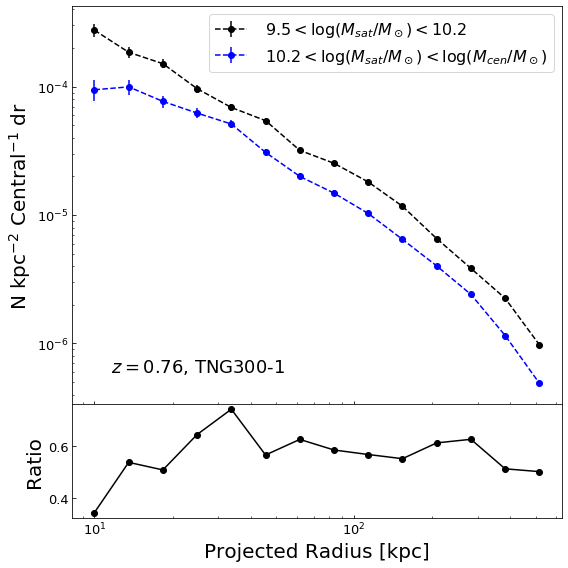

In [12]:
# split low/high sat mass

fig, axs = plt.subplots(2,1, sharex=True,sharey='row', figsize=(8, 8),gridspec_kw={'height_ratios':[3.5,1]})
z=0.76

sim = 'TNG'
basPath = 'sims.'+sim+'/TNG300-1/output/'

# sim = 'illustris'
# basPath = 'sims.'+sim+'/Illustris-1/output'

m_il,s_il=load_subhalo_halo(basPath,57,11.15)
radial_tot_lm,radial_tot_lm_err ,count_lm = radial(m_il,s_il,z,9.5,10.2)
radial_tot_hm,radial_tot_hm_err ,count_hm = radial(m_il,s_il,z,10.2,13.0)

curve_hm = radial_tot_hm/areas/count_hm
curve_lm = radial_tot_lm/areas/count_lm
error_hm = radial_tot_hm_err/areas/count_hm
error_lm = radial_tot_lm_err/areas/count_lm
hm_tuple = (curve_hm,error_hm)
lm_tuple = (curve_lm,error_lm)

np.save('radial_hm_4.npy',np.asarray(hm_tuple))
np.save('radial_lm_4.npy' ,np.asarray(lm_tuple))

axs[0].errorbar(bin_edges[:-1],curve_lm,yerr=radial_tot_lm_err/areas/count_lm,
             fmt='ok--',label=' $9.5<\log(M_{sat}/M_\odot)<10.2$')
axs[0].errorbar(bin_edges[:-1],curve_hm,yerr=radial_tot_hm_err/areas/count_hm,
             fmt='ob--',label=' $10.2<\log(M_{sat}/M_\odot)<\log(M_{cen}/M_\odot)$')

axs[1].errorbar(bin_edges[:-1],curve_hm/curve_lm,yerr=radial_tot_hm_err/areas/count_hm,
             fmt='ok-',label=str(z)+' tng 10.2 - ')

axs[0].annotate(r'$z='+str(z)+'$, TNG300-1',xy=([0.08,0.08]),xycoords='axes fraction',fontsize=18,color='k')
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].legend(fontsize=16,loc='upper right')
axs[1].set_xlabel('Projected Radius [kpc]', fontsize=20)
axs[0].set_ylabel('N kpc$^{-2}$ Central$^{-1}$ dr', fontsize=20)
axs[1].set_ylabel('Ratio', fontsize=20)
plt.tight_layout()
fig.subplots_adjust(hspace=0)

plt.savefig('split_sat_mass_'+sim+'_'+str(z)+'.png')

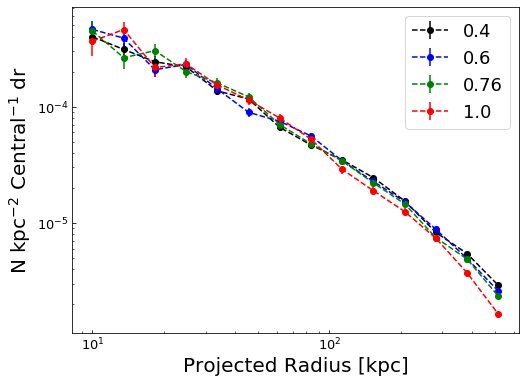

In [36]:
fig, axs = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(8, 6))
central_masscut = 11.23-0.16*z
sim = 'TNG'
basPath = 'sims.'+sim+'/TNG300-1/output/'

# sim = 'illustris'
# basPath = 'sims.'+sim+'/Illustris-1/output'

radial_tot_tng,radial_tot_tng_err, count_tng = np.load('radial_tng_0.4_9.5_12.0.npy',allow_pickle=True)
radial_tot_tng2,radial_tot_tng2_err, count_tng2 = np.load('radial_tng_0.6_9.5_12.0.npy',allow_pickle=True)
radial_tot_tng3,radial_tot_tng3_err, count_tng3 = np.load('radial_tng_0.76_9.5_12.0.npy',allow_pickle=True)
radial_tot_tng4,radial_tot_tng4_err, count_tng4 = np.load('radial_tng_1.0_9.5_12.0.npy',allow_pickle=True)

plt.errorbar(bin_edges[:-1],radial_tot_tng/areas/count_tng,yerr=radial_tot_tng_err/areas/count_tng,fmt='ok--',label='0.4')
plt.errorbar(bin_edges[:-1],radial_tot_tng2/areas/count_tng2,yerr=radial_tot_tng2_err/areas/count_tng2,fmt='ob--',label='0.6')
plt.errorbar(bin_edges[:-1],radial_tot_tng3/areas/count_tng3,yerr=radial_tot_tng3_err/areas/count_tng3,fmt='og--',label='0.76')
plt.errorbar(bin_edges[:-1],radial_tot_tng4/areas/count_tng4,yerr=radial_tot_tng4_err/areas/count_tng4,fmt='or--',label='1.0')

plt.xscale('log')
plt.yscale('log')

plt.legend(fontsize=18)
plt.xlabel('Projected Radius [kpc]', fontsize=20)
plt.ylabel('N kpc$^{-2}$ Central$^{-1}$ dr', fontsize=20)
plt.savefig('z_dependence_'+sim+'.png')

massive gals: 683 , isolated centrals: 683
massive gals: 5317 , isolated centrals: 5316


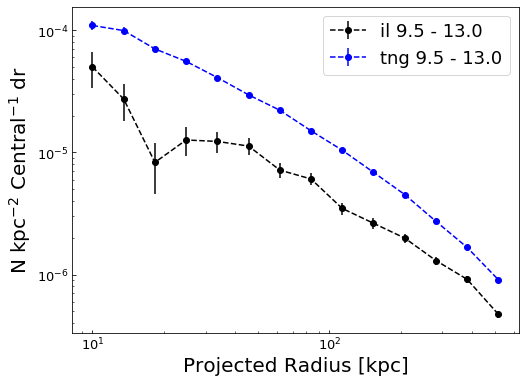

In [17]:
fig, axs = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(8, 6))

path = 'sims.illustris/Illustris-1/output'
m_il,s_il=load_subhalo_halo(path,134,10.8)
path = 'sims.TNG/TNG300-1/output/'
m_tng,s_tng=load_subhalo_halo(path,99,10.8)

radial_tot_il,radial_tot_il_err, count_il = radial(m_il,s_il,0,9.5,13.0)
radial_tot_tng,radial_tot_tng_err, count_tng = radial(m_tng,s_tng,0,9.5,13.0)

plt.errorbar(bin_edges[:-1],radial_tot_il/areas/count_il ,
             yerr=radial_tot_il_err/areas/count_il,fmt='ok--',label='il 9.5 - 13.0')
plt.errorbar(bin_edges[:-1],radial_tot_tng/areas/count_tng,
             yerr=radial_tot_tng_err/areas/count_tng,fmt='ob--',label='tng 9.5 - 13.0')

plt.xscale('log')
plt.yscale('log')

plt.legend(fontsize=18)
plt.xlabel('Projected Radius [kpc]', fontsize=20)
plt.ylabel('N kpc$^{-2}$ Central$^{-1}$ dr', fontsize=20)
plt.savefig('compare_IL_TNG.png')


massive gals: 210 , isolated centrals: 210
massive gals: 210 , isolated centrals: 210
massive gals: 210 , isolated centrals: 210


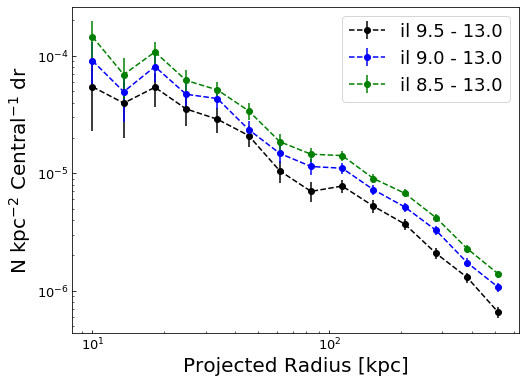

In [18]:
fig, axs = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(8, 6))

path = 'sims.illustris/Illustris-1/output'
m_il,s_il=load_subhalo_halo(path,108,11.15)

radial_tot_il,radial_tot_il_err, count_il = radial(m_il,s_il,0.4,9.5,13.0)
radial_tot_il2,radial_tot_il2_err, count_il2 = radial(m_il,s_il,0.4,9.0,13.0)
radial_tot_il3,radial_tot_il3_err, count_il3 = radial(m_il,s_il,0.4,8.5,13.0)

plt.errorbar(bin_edges[:-1],radial_tot_il/areas/count_il,yerr=radial_tot_il_err/areas/count_il,
             fmt='ok--',label='il 9.5 - 13.0')
plt.errorbar(bin_edges[:-1],radial_tot_il2/areas/count_il2,yerr=radial_tot_il2_err/areas/count_il2,
             fmt='ob--',label='il 9.0 - 13.0')
plt.errorbar(bin_edges[:-1],radial_tot_il3/areas/count_il3,yerr=radial_tot_il3_err/areas/count_il3,
             fmt='og--',label='il 8.5 - 13.0')

plt.xscale('log')
plt.yscale('log')

plt.legend(fontsize=18)
plt.xlabel('Projected Radius [kpc]', fontsize=20)
plt.ylabel('N kpc$^{-2}$ Central$^{-1}$ dr', fontsize=20)
plt.savefig('compare_IL_sat_masscut.png')


massive gals: 756 , isolated centrals: 753
massive gals: 756 , isolated centrals: 751
massive gals: 756 , isolated centrals: 486


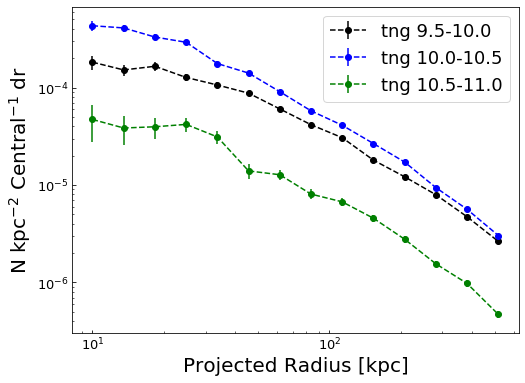

In [20]:
fig, axs = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(8, 6))

m_il,s_il=load_subhalo_halo('sims.TNG/TNG300-1/output/',72, 11.15)
radial_tot_tng,radial_tot_tng_err, count_tng = radial(m_il,s_il,0.4,8.0,9.0)
radial_tot_tng2,radial_tot_tng2_err, count_tng2 = radial(m_il,s_il,0.4,9.0,11.0)
radial_tot_tng3,radial_tot_tng3_err, count_tng3 = radial(m_il,s_il,0.4,10.5,11.0)

plt.errorbar(bin_edges[:-1],radial_tot_tng/areas/count_tng,yerr=radial_tot_tng_err/areas/count_tng,
             fmt='ok--',label='tng 9.5-10.0')
plt.errorbar(bin_edges[:-1],radial_tot_tng2/areas/count_tng2,yerr=radial_tot_tng2_err/areas/count_tng2,
             fmt='ob--',label='tng 10.0-10.5')
plt.errorbar(bin_edges[:-1],radial_tot_tng3/areas/count_tng3,yerr=radial_tot_tng3_err/areas/count_tng3,
             fmt='og--',label='tng 10.5-11.0')

plt.xscale('log')
plt.yscale('log')

plt.legend(fontsize=18)
plt.xlabel('Projected Radius [kpc]', fontsize=20)
plt.ylabel('N kpc$^{-2}$ Central$^{-1}$ dr', fontsize=20)
plt.savefig('split_sat_mass_TNG.png')


massive gals: 210 , isolated centrals: 210
massive gals: 169 , isolated centrals: 169
massive gals: 76 , isolated centrals: 76


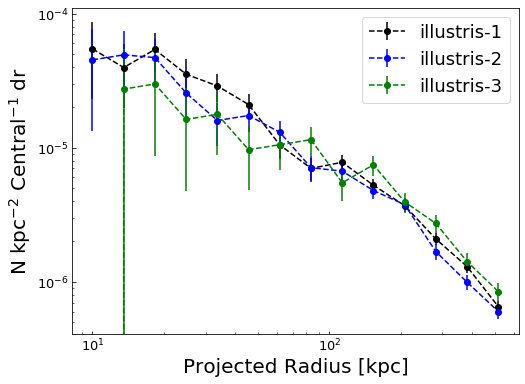

In [21]:
fig, axs = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(8, 6))

snap = 108
z = 0.4

m_il,s_il=load_subhalo_halo('./sims.illustris/Illustris-1/output',snap,11.15)
radial_tot_il,radial_tot_il_err, count_il = radial(m_il,s_il,z,9.5,13.0)

m_il2,s_il2=load_subhalo_halo('./sims.illustris/Illustris-2/output',snap,11.15)
radial_tot_il2,radial_tot_il2_err, count_il2 = radial(m_il2,s_il2,z,9.5,13.0)

m_il3,s_il3=load_subhalo_halo('./sims.illustris/Illustris-3/output',snap,11.15)
radial_tot_il3,radial_tot_il3_err, count_il3 = radial(m_il3,s_il3,z,9.5,13.0)

plt.errorbar(bin_edges[:-1],radial_tot_il/areas/count_il,yerr=radial_tot_il_err/areas/count_il,fmt='ok--',label='illustris-1')
plt.errorbar(bin_edges[:-1],radial_tot_il2/areas/count_il2,yerr=radial_tot_il2_err/areas/count_il2,fmt='ob--',label='illustris-2')
plt.errorbar(bin_edges[:-1],radial_tot_il3/areas/count_il3,yerr=radial_tot_il3_err/areas/count_il3,fmt='og--',label='illustris-3')

plt.xscale('log')
plt.yscale('log')

plt.legend(fontsize=18)
plt.xlabel('Projected Radius [kpc]', fontsize=20)
plt.ylabel('N kpc$^{-2}$ Central$^{-1}$ dr', fontsize=20)
plt.savefig('compare_IL_criteria.png')


massive gals: 92 , isolated centrals: 92
massive gals: 756 , isolated centrals: 756


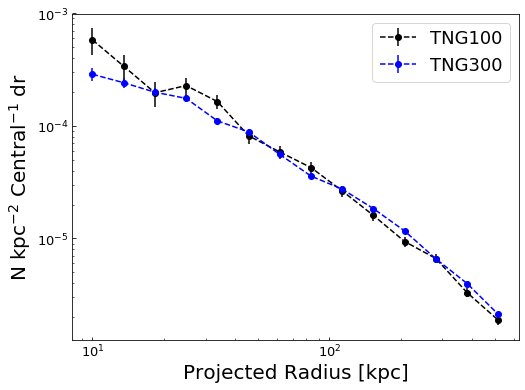

In [22]:
fig, axs = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(8, 6))

snap = 72
z = 0.4

m_tng,s_tng=load_subhalo_halo('sims.TNG/TNG100-1/output/',snap,11.15)
radial_tot_tng,radial_tot_tng_err, count_tng = radial(m_tng,s_tng,z,9.5,13.0)
m_tng2,s_tng2=load_subhalo_halo('sims.TNG/TNG300-1/output/',snap,11.15)
radial_tot_tng2,radial_tot_tng2_err, count_tng2 = radial(m_tng2,s_tng2,z,9.5,13.0)

plt.errorbar(bin_edges[:-1],radial_tot_tng/areas/count_tng,yerr=radial_tot_tng_err/areas/count_tng,fmt='ok--',label='TNG100')
plt.errorbar(bin_edges[:-1],radial_tot_tng2/areas/count_tng2,yerr=radial_tot_tng2_err/areas/count_tng2,fmt='ob--',label='TNG300')

plt.xscale('log')
plt.yscale('log')

plt.legend(fontsize=18)
plt.xlabel('Projected Radius [kpc]', fontsize=20)
plt.ylabel('N kpc$^{-2}$ Central$^{-1}$ dr', fontsize=20)
plt.savefig('compare_IL_TNG_obs_criteria.png')

### three projections

massive gals: 92 , isolated centrals: 92
massive gals: 92 , isolated centrals: 92
massive gals: 92 , isolated centrals: 92


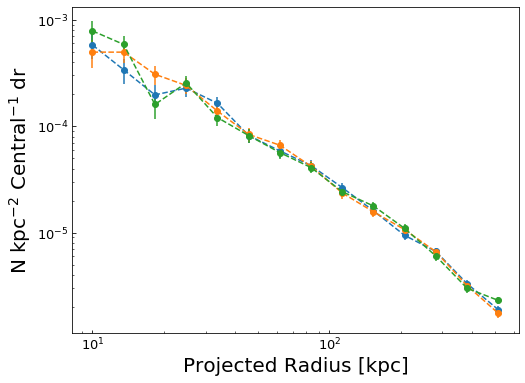

In [12]:
fig, axs = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(8, 6))

snap = 72
z = 0.4
m_tng,s_tng=load_subhalo_halo('sims.TNG/TNG100-1/output/',snap,11.15)

for proj_collapse in [0,1,2]:
    massive_central_halos, subhalos = load_subhalo_halo('sims.TNG/TNG100-1/output/',snap,11.15)
    radial_tot, radial_tot_err, massive_count = radial(massive_central_halos,subhalos,z, 
                                                             9.5, 13.0, proj_collapse)
    plt.errorbar(bin_edges[:-1],radial_tot/areas/massive_count,
                 yerr=np.sqrt(radial_tot)/areas/massive_count,fmt='o--')

plt.xscale('log')
plt.yscale('log')

plt.xlabel('Projected Radius [kpc]', fontsize=20)
plt.ylabel('N kpc$^{-2}$ Central$^{-1}$ dr', fontsize=20)
plt.savefig('three_projection_0.4.png')

massive gals: 210 , isolated centrals: 210
massive gals: 186 , isolated centrals: 185
massive gals: 155 , isolated centrals: 155


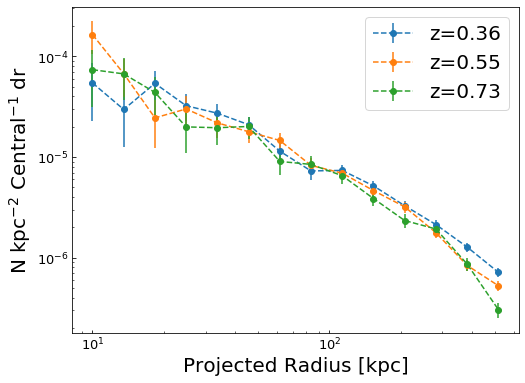

In [8]:
fig, axs = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(8, 6))
tng_time = Table.read('illustris_snap_time.csv')
    
for snap in [108, 99, 92]:
    z = tng_time[snap]['Redshift']
    massive_central_halos, subhalos = load_subhalo_halo('./sims.illustris/Illustris-1/output',snap,11.15)
    radial_tot_1, radial_tot_1_err, massive_count_1 = radial(massive_central_halos,subhalos,z, 9.5, 13.0)
    plt.errorbar(bin_edges[:-1],radial_tot_1/areas/massive_count_1,yerr=np.sqrt(radial_tot_1)/areas/massive_count_1,
                 fmt='o--',label='z='+str(z))

plt.xscale('log')
plt.yscale('log')

plt.xlabel('Projected Radius [kpc]', fontsize=20)
plt.ylabel('N kpc$^{-2}$ Central$^{-1}$ dr', fontsize=20)
plt.legend(fontsize=20)
plt.savefig('three_redshifts.png')

### split central/Satellite sfq

1. split by $g-r$ color
2. split by sSFR

In [5]:
massive_central_halos,subhalos = load_subhalo_halo('sims.TNG/TNG100-1/output/',72,11.15)
subhalos = subhalos[subhalos['SubhaloStellarPhotometricsMassInRad']>0.316*0.704]
subhalos['SubhaloSFR'][subhalos['SubhaloSFR']==0.0] = 1e-5

g_r = subhalos['SubhaloStellarPhotometrics'][:,4] - subhalos['SubhaloStellarPhotometrics'][:,5]
mass = np.log10(subhalos['SubhaloStellarPhotometricsMassInRad']/0.704)+10

log_ssfr = np.log10(subhalos['SubhaloSFR']/(subhalos['SubhaloStellarPhotometricsMassInRad']*1e10/0.704))

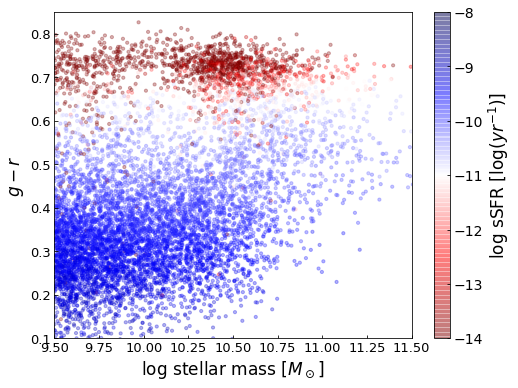

In [6]:
fig, axs = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(8, 6))
plt.scatter(mass, g_r,s=10,alpha=0.3,c=log_ssfr,
           vmin=-14, vmax=-8, cmap='seismic_r')

cbar = plt.colorbar() 
cbar.ax.tick_params(labelsize=14) 
cbar.set_label(r'log sSFR [$\log(yr^{-1})$]',size=17)

plt.xlim([9.5,11.5])
plt.ylim([0.1,0.85])
plt.xlabel(r'log stellar mass [$M_\odot$]',fontsize=17)
plt.ylabel(r'$g-r$',fontsize=17)
plt.show() 

### quiescent centrals have more satellites?

Kawin+2014

In [6]:
massive_central_halos,subhalos = load_subhalo_halo('sims.TNG/TNG300-1/output/',72,11.15)
centrals = subhalos[massive_central_halos['GroupFirstSub']]
log_ssfr_central = np.log10(centrals['SubhaloSFR']/(centrals['SubhaloStellarPhotometricsMassInRad']*1e10/0.704))

q_central_halos = massive_central_halos[log_ssfr_central < -11]
sf_central_halos = massive_central_halos[log_ssfr_central > -11]
print(len(q_central_halos),len(sf_central_halos))

430 326


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


massive gals: 430 , isolated centrals: 430
massive gals: 326 , isolated centrals: 326


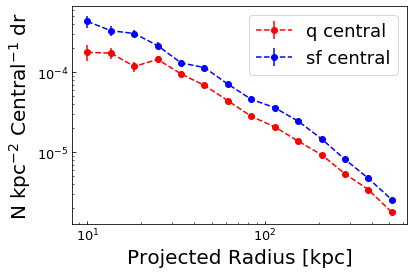

In [8]:
# Obtain `N_BINS` equal frequency bins, in other words percentiles
# N_BINS = 30
# SAMPLE_SIZE=200
# step = 100 / N_BINS

# sf_central_percentiles = [
#     np.percentile(subhalos[sf_central_halos['GroupFirstSub']]['SubhaloStellarPhotometricsMassInRad'], q, axis=0)
#     for q in np.arange(start=step, stop=100, step=step)
# ]

# # Match each observation in the training set to a bin
# q_central_bins = np.digitize(subhalos[q_central_halos['GroupFirstSub']]['SubhaloStellarPhotometricsMassInRad'], sf_central_percentiles)

# # Count the number of values in each training set bin
# q_central_bin_counts = np.bincount(q_central_bins)

# # Weight each observation in the training set based on which bin it is in
# weights = 1 / np.array([q_central_bin_counts[x] for x in q_central_bins])

# # Make the weights sum up to 1
# weights_norm = weights / np.sum(weights)

# np.random.seed(0)
# q_central_halos_matched = np.random.choice(q_central_halos, size=SAMPLE_SIZE, p=weights_norm, replace=False)

sat_masscut=9.5
radial_tot_q,radial_tot_q_err, count_q = radial(q_central_halos,subhalos,0.4,sat_masscut,13.0)
radial_tot_sf,radial_tot_sf_err, count_sf = radial(sf_central_halos,subhalos,0.4,sat_masscut,13.0)

plt.errorbar(bin_edges[:-1],radial_tot_q/areas/count_q,yerr=radial_tot_q_err/areas/count_q,
             fmt='or--',label='q central')
plt.errorbar(bin_edges[:-1],radial_tot_sf/areas/count_sf,yerr=radial_tot_sf_err/areas/count_sf,
             fmt='ob--',label='sf central')

plt.xscale('log')
plt.yscale('log')

plt.legend(fontsize=18)
plt.xlabel('Projected Radius [kpc]', fontsize=20)
plt.ylabel('N kpc$^{-2}$ Central$^{-1}$ dr', fontsize=20)
plt.savefig('sf_q_central.png')

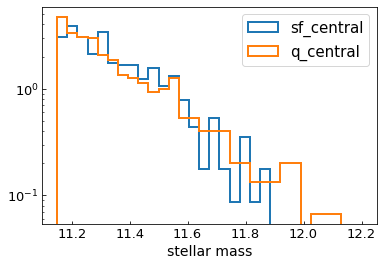

In [10]:
plt.hist(np.log10(subhalos[sf_central_halos['GroupFirstSub']]['SubhaloStellarPhotometricsMassInRad']/0.704)+10,
         range=(11.15,12.2),density=True,
         histtype='step',linewidth=2,bins=30,label='sf_central')
plt.hist(np.log10(subhalos[q_central_halos['GroupFirstSub']]['SubhaloStellarPhotometricsMassInRad']/0.704)+10,
         range=(11.15,12.2),density=True,
         histtype='step',linewidth=2,bins=30,label='q_central')

plt.yscale('log')
plt.legend(fontsize=15)
plt.xlabel('stellar mass',fontsize=14)
plt.savefig('central_stellar_mass_hist.png')

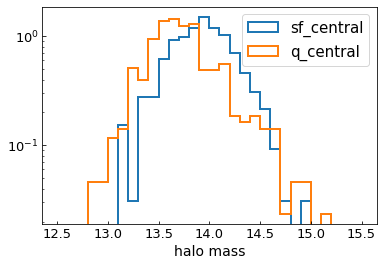

In [11]:
plt.hist(np.log10(sf_central_halos['GroupMass']/0.704)+10,
         range=(12.5,15.5),density=True,
         histtype='step',linewidth=2,bins=30,label='sf_central')
plt.hist(np.log10(q_central_halos['GroupMass']/0.704)+10,
         range=(12.5,15.5),density=True,
         histtype='step',linewidth=2,bins=30,label='q_central')

plt.yscale('log')
plt.xlabel('halo mass',fontsize=14)
plt.legend(fontsize=15)
plt.savefig('central_halo_mass_hist.png')

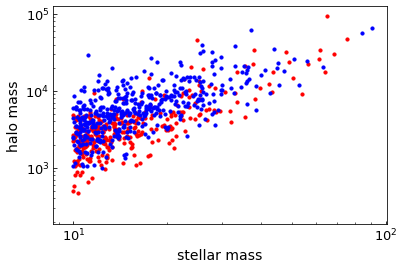

In [8]:
plt.scatter(subhalos[q_central_halos['GroupFirstSub']]['SubhaloStellarPhotometricsMassInRad'],
            q_central_halos['GroupMass'],color='r',s=10)
plt.scatter(subhalos[sf_central_halos['GroupFirstSub']]['SubhaloStellarPhotometricsMassInRad'],
            sf_central_halos['GroupMass'],color='b',s=10)

plt.yscale('log')
plt.xscale('log')
plt.xlabel('stellar mass',fontsize=14)
plt.ylabel('halo mass',fontsize=14)
plt.savefig('central_stellar_halo_mass.png')

### Conformity?

massive gals: 272 , isolated centrals: 272
massive gals: 272 , isolated centrals: 269
massive gals: 1187 , isolated centrals: 1186
massive gals: 1187 , isolated centrals: 953


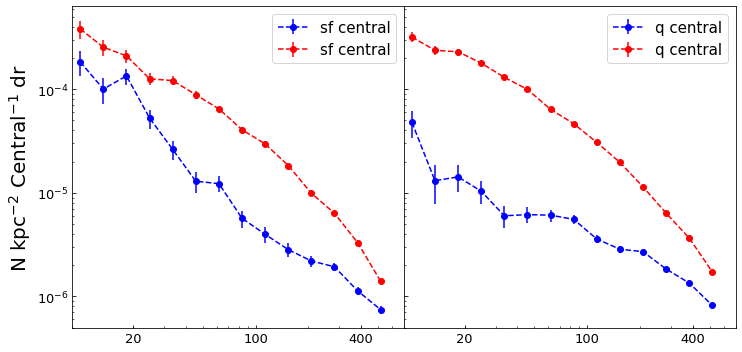

In [26]:
# check galaxy conformity
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10,5))
sat_masscut=9.5

# subhalos_sf = subhalos[log_ssfr_sats>-11]
# subhalos_q = subhalos[log_ssfr_sats<-11]
radial_csf_ssf,radial_csf_ssf_err, count_csf = radial(sf_central_halos,subhalos,0.0,sat_masscut,13.0,ssfq='ssf')
radial_csf_sq,radial_csf_sq_err, count_csf = radial(sf_central_halos,subhalos,0.0,sat_masscut,13.0,ssfq='sq')

radial_cq_sq,radial_cq_sq_err, count_cq = radial(q_central_halos,subhalos,0.0,sat_masscut,13.0,ssfq='sq')
radial_cq_ssf,radial_cq_ssf_err, count_cq = radial(q_central_halos,subhalos,0.0,sat_masscut,13.0,ssfq='ssf')

axs[0].errorbar(bin_edges[:-1],radial_csf_ssf/areas/count_csf,yerr=radial_csf_ssf_err/areas/count_csf,
                fmt='ob--',label='sf central')
axs[0].errorbar(bin_edges[:-1],radial_csf_sq/areas/count_csf,yerr=radial_csf_sq_err/areas/count_csf,
                fmt='or--',label='sf central')

axs[1].errorbar(bin_edges[:-1],radial_cq_ssf/areas/count_cq,yerr=radial_cq_ssf_err/areas/count_cq,
                fmt='ob--',label='q central')
axs[1].errorbar(bin_edges[:-1],radial_cq_sq/areas/count_cq,yerr=radial_cq_sq_err/areas/count_cq,
                fmt='or--',label='q central')

axs[0].legend(fontsize=15)
axs[1].legend(fontsize=15)
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlim([9,700])
axs[0].set_xticks([20, 100, 400])
axs[0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.tight_layout()
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)

axs[0].set_ylabel('N kpc$^{-2}$ Central$^{-1}$ dr',fontsize=20)
plt.savefig('conforminty_z0.png')

## Trace centrals through redshift
1. list of centrals in SnapNum=N
2. walk back merger tree to SnapNum=N-1
3. find first progenitors (use SubfindID) in SnapNum=N-1
4. repeat to SnapNum = N-2 and so on

In [3]:
basePath = 'sims.TNG/TNG300-1/output/'
last_snap = 99    # z=0
snap_start = 50   # z=1.0
snap_end = 76 # z=0.4

# basePath = './sims.illustris/Illustris-1/output/'
# last_snap = 135
# snap_start = 91

#========================================
header = il.groupcat.loadHeader(basePath,0)
boxsize = header['BoxSize']
track = 'later'

In [4]:
from astropy.coordinates import SkyCoord
import astropy.units as u

bin_number = 20
bin_edges = 10 ** np.linspace(1.0, 3.225, num=bin_number + 1)
areas = np.array([])
for i in range(len(bin_edges[:-1])):
    areas = np.append(areas, (bin_edges[i + 1] ** 2 - bin_edges[i] ** 2) * np.pi)

# load in time,z,snap relation
if 'TNG' in basePath:
    tng_time = Table.read('TNG_snap_time.csv')
    z_list = tng_time['z']
else:
    illustris_time = Table.read('illustris_snap_time.csv')
    z_list = illustris_time['Redshift']

def radial_count(snap, z_list, massive_central_halos, halo_ids,track='prev',save_cats=True):
    z = z_list[snap]
    a = 1/(1+z)
    
    # load subhalos at snap_start
    fields = ['SubhaloPos','SubhaloMass','SubhaloStellarPhotometricsMassInRad','SubhaloMassInRadType',
              'SubhaloStellarPhotometrics','SubhaloSFR']
    subhalos = il.groupcat.loadSubhalos(basePath,snap,fields=fields)
    del subhalos['count']
    subhalos = Table(subhalos)
    subhalos.add_column(Column(data=np.arange(len(subhalos)),name='id'))
    
    # satellite galaxy mass cut logM=9.5    
    sat_masscut = 10**(9.5-10)
    subhalos_masscut = subhalos[subhalos['SubhaloMassInRadType'][:,4]>sat_masscut*0.704]  # x*10^10 M_sun / h
    tree = KDTree(subhalos_masscut['SubhaloPos'])
    tree_2d = KDTree(subhalos_masscut['SubhaloPos'][:,1:])
    
    radial_tot = np.zeros(bin_number)
    massive_count = 0
    on_edge_count = 0
    total_sat_num = 0
    total_merged = 0
    total_not_in_tree = 0
    halo_ids_checked = [] # checked to have satellites and is a central
    for i in range(len(massive_central_halos)):
        halo = massive_central_halos[i]
        halo_id = halo_ids[i]
        
        # the central galaxy for each halo
        first_subhalo = subhalos[halo['GroupFirstSub']]
        
        # cut central galaxy that is close to box edge
        central_on_edge = False
        for k in range(3):
            if abs(boxsize/2-first_subhalo['SubhaloPos'][k])>boxsize/2-bin_edges[-1]:
                central_on_edge = True
                on_edge_count += 1
        if central_on_edge == True: 
            continue
        
        # exclude halo if its central is more than 10 ckpc/h away from the halo center
        if np.linalg.norm(first_subhalo['SubhaloPos']-halo['GroupPos'])>10: 
            continue
            
        # cut the satellite catalog
        ind = tree_2d.query_radius([halo['GroupPos'][1:]],bin_edges[-1]/a*0.704,count_only=False) # comoving kpc / h
        cat_neighbors = subhalos_masscut[ind[0]]
        cat_neighbors = cat_neighbors[abs(cat_neighbors['SubhaloPos'][:,0]-halo['GroupPos'][0])<bin_edges[-1]*0.704]
        
        # isolation criteria
        cat_bright_neighbors = cat_neighbors[cat_neighbors['SubhaloMassInRadType'][:,4]>first_subhalo['SubhaloMassInRadType'][4]]
        if len(cat_bright_neighbors)>=1: 
            print('a more massive companion!','No. of more massive satellites:',len(cat_bright_neighbors))
            continue
        elif len(cat_neighbors)<=1:
            print('no sats!')
            continue
        else:
            halo_ids_checked.append(halo_id)
            
        # remove central from cat_neighbors
        max_mass_index = np.argmax(cat_neighbors['SubhaloMassInRadType'][:,4]) # index of central in catneighbors
        cat_neighbors = np.delete(cat_neighbors, max_mass_index) # remove central from cat_neighbors
        
        # keep record of satellites of this halo and their progenitors/decendants
        if save_cats == True:
            if track == 'prev':
                cat_neighbors = sat_prev(halo_id, z, cat_neighbors,snap_start=snap,snap_end=snap_end,halo=halo)
            elif track == 'later':
                cat_neighbors, merged, disrupted, not_in_tree = sat_later(halo_id, z, cat_neighbors, snap_start=snap,snap_end=snap_end,halo=halo)
                total_sat_num += len(cat_neighbors)
                total_merged += merged
                total_not_in_tree += not_in_tree
            if len(cat_neighbors)==0:
                print('no sats!')
                continue
            
        # calculation (2D selection for radial distribution)
        radial = []        
        subtree = KDTree(cat_neighbors['SubhaloPos'][:,1:])
        for bin_edge in bin_edges:
            ind = subtree.query_radius([halo['GroupPos'][1:]],bin_edge/a*0.704,count_only=True) # comoving kpc / h
            radial.append(ind[0])
        
        radial = np.diff(np.array(radial))
        radial_tot += radial
        massive_count += 1
    
    print('massive gals:',len(massive_central_halos),', isolated centrals:',massive_count,', on edge:',on_edge_count)
    print('Number counts for satellites. Survived:',total_sat_num,'Merged:',total_merged,
          'Skippped snaps',disrupted,'Not in tree:',total_not_in_tree)
    return radial_tot, massive_count, halo_ids_checked


# keep track of satellites in previous snapshots
def sat_prev(halo_id, z, cat_neighbors, snap_start, snap_end, halo):
    sat_ids = cat_neighbors['id']
    sat_prev_tot_ids = np.ones(snap_start-snap_end)
    mask = []
    for i, sat_id in enumerate(sat_ids):
        sat_prev = il.sublink.loadTree(basePath,snap_start,sat_id,fields=['SubfindID','SnapNum'],onlyMPB=True)
        if sat_prev != None: # the satellite is in a tree
            sat_prev_ids = sat_prev['SubfindID'][:snap_start-snap_end]
            if sat_prev_tot_ids.shape[-1]==len(sat_prev_ids): # satellite has progenitor up to snap_end
                sat_prev_tot_ids = np.vstack([sat_prev_tot_ids, sat_prev_ids])
                mask.append(True)
            else: 
                mask.append(False)
        else:
            mask.append(False)
    
    cat_neighbors = cat_neighbors[mask]
    cat_neighbors['SubhaloSFR'][cat_neighbors['SubhaloSFR']==0.0] = 1e-5
    cat_logssfr = np.log10(cat_neighbors['SubhaloSFR']/1e10/0.704/cat_neighbors['SubhaloMassInRadType'][:,4])
    sat_prev_tot_ids = sat_prev_tot_ids[1:]
    
    # record distance list at snap_start
    distance_list(snap_start, z, cat_neighbors, halo['GroupPos'][1:],halo_id, sat_ids, save_dir='sat_catalogs/')
    distance_list_3d(snap_start, z, cat_neighbors, halo['GroupPos'],halo_id, sat_ids, save_dir='sat_catalogs/')
    
    # record id in later snapshots
    np.save('sat_catalogs/'+str(halo_id)+'_logssfr_sats.npy',cat_logssfr)
    np.save('sat_catalogs/'+str(halo_id)+'_sats.npy',sat_prev_tot_ids)
    
    # return cat_neighbors in snap_start
    if len(cat_neighbors)>0:
        return cat_neighbors
    else:
        return np.array([])
    

# keep track of satellites in later snapshots
def sat_later(halo_id, z, cat_neighbors, snap_start, snap_end, halo):
    sat_ids = cat_neighbors['id']
    sat_later_tot_ids = np.array([np.ones(snap_end-snap_start+1)])
    mask = [] 
    mask_merged = []
    merged_list = []
    disrupted_list = []
    not_in_tree = 0
    for i, sat_id in enumerate(sat_ids):
        sat_later = il.sublink.loadTree(basePath,snap_start,sat_id,fields=['SubfindID','SnapNum'],onlyMDB=True)
        
        if sat_later != None: # the satellite is in a tree
            
            if len(sat_later['SubfindID'])!= abs(snap_start-last_snap):  # last_snap=99 for TNG and 135 for il
                mask.append(False)
                
                # if get the full merger tree --> merged satellites
                if len(sat_later['SubfindID'])> abs(snap_start-last_snap):
                    merged_list.append(sat_id)
                    mask_merged.append(True)
                
                # if MDB skip a few snaps (may be survived satellites)
                else:
                    disrupted_list.append(sat_id)
                    mask_merged.append(False)
            
            # survived satellites
            else:
                mask_merged.append(False)
                sat_later_ids = sat_later['SubfindID'][snap_start-snap_end:]
                
                if sat_later_tot_ids.shape[-1]==len(sat_later_ids)+1:  # satellite has decendant until snap_end
                    sat_later_tot_ids = np.vstack([sat_later_tot_ids, np.append(sat_id,np.flip(sat_later_ids,axis=0))])
                    mask.append(True)
                else: 
                    mask.append(False)
                    
        # the satellite is NOT in a tree      
        else: 
            mask.append(False)
            mask_merged.append(False)
            not_in_tree += 1
    
    cat_merged = cat_neighbors[mask_merged]
    cat_neighbors = cat_neighbors[mask]
    cat_neighbors['SubhaloSFR'][cat_neighbors['SubhaloSFR']==0.0] = 1e-5
    cat_logssfr = np.log10(cat_neighbors['SubhaloSFR']/(cat_neighbors['SubhaloMassInRadType'][:,4]*1e10/0.704))
    
    # record distance list at snap_start
    distance_list(snap_start, z, cat_neighbors, halo['GroupPos'][1:],halo_id,sat_ids, save_dir='sat_catalogs_later/')
    distance_list_3d(snap_start, z, cat_neighbors, halo['GroupPos'],halo_id,sat_ids, save_dir='sat_catalogs_later/')
    distance_list_3d(snap_start, z, cat_merged, halo['GroupPos'],halo_id,merged_list, save_dir='sat_catalogs_later/',type='_merged')
    
    # record id in later snapshots
    sat_later_tot_ids = sat_later_tot_ids[1:]
    np.save('sat_catalogs_later/'+str(halo_id)+'_merged_sats.npy',merged_list)
    np.save('sat_catalogs_later/'+str(halo_id)+'_disrupted_sats.npy',disrupted_list)
    np.save('sat_catalogs_later/'+str(halo_id)+'_logssfr_sats.npy',cat_logssfr)
    np.save('sat_catalogs_later/'+str(halo_id)+'_sats.npy',sat_later_tot_ids)
    
    # return cat_neighbors in snap_start
    return cat_neighbors, len(merged_list),len(disrupted_list), not_in_tree
    

def read_satellite_cat(subhalos, halo_id_start, snap, snap_start, save_dir):
    sat_ids = np.load(save_dir+str(halo_id_start)+'_sats.npy')
    if len(sat_ids.shape)==2:
        sat_ids_this_snap = sat_ids[:,abs(snap_start-snap)]
        sat_ids_snap_start = sat_ids[:,0]
        sat_cat = subhalos[sat_ids_this_snap.astype(int)]
        return sat_cat, sat_ids_snap_start
    
    else:
        print('no satellites for:',halo_id_start)
        return np.array([]), np.array([])
    

def radial_count_prev(snap, z_list, halo_ids_start, halo_ids, halo_ids_start_checked, subhalos):
    z = z_list[snap]
    a = 1/(1+z) # scale factor
    radial_tot = np.zeros(len(bin_edges)-1)
    
    halo_sat_saved_number = 0
    for i in range(len(halo_ids)):
        halo_id_start = halo_ids_start[i]
        halo_id = halo_ids[i]
        
        # load halo
        save_dir = 'sat_catalogs/' if track=='prev' else 'sat_catalogs_later/'
        halo = il.groupcat.loadSingle(basePath,snap,haloID=halo_id)
        
        # check if central galaxy of this halo satisfies all criteria
        if halo_id_start not in halo_ids_start_checked:
            try:
                os.system('rm '+save_dir+'/distance_list_3d_'+str(snap_start)+'_'+str(halo_id_start)+'.npy')
            except FileNotFoundError:
                pass
            
            continue
            
        # read in satellite catalogs in this snapshot
        try:
            sat_cat, sat_ids_start = read_satellite_cat(subhalos, halo_id_start, snap, snap_start, save_dir=save_dir)
            if len(sat_cat)==0: 
                print('no sat for halo '+str(halo_id_start)+' (id at snap_start)')
                continue
            elif len(sat_cat) != len(sat_ids_start):
                print('no. of sat do not match between snaps')
                continue
                
        except FileNotFoundError:
            print(halo_id_start,'not found')
            continue
        
        # save distance list for satellites
        distance_list(snap, z, sat_cat, halo['GroupPos'][1:], halo_id_start, sat_ids_start, save_dir=save_dir)
        distance_list_3d(snap, z, sat_cat, halo['GroupPos'], halo_id_start, sat_ids_start, save_dir=save_dir)
        halo_sat_saved_number += 1
        
        # the calculation
        radial = []
        subtree = KDTree(sat_cat['SubhaloPos'][:,1:])  # ready for 2d spatial selection
        for bin_edge in bin_edges:
            ind = subtree.query_radius([halo['GroupPos'][1:]],bin_edge/a*0.704,count_only=True) # comoving kpc / h
            radial.append(ind[0])
            
        radial = np.diff(np.array(radial))
        radial_tot += radial
    
    print('satellite distance saved for '+ str(halo_sat_saved_number)+' halos.')
    return radial_tot, massive_count


def distance_list(snap, z, cat_sat, central_coord, halo_id, sat_ids_start, save_dir = 'sat_catalogs/'):
    a = 1/(1+z)
    cat_sat_x = cat_sat['SubhaloPos'][:,1]
    cat_sat_y = cat_sat['SubhaloPos'][:,2]
    central_x = central_coord[0]
    central_y = central_coord[1]
    
    distance_list = []
    for i in range(len(cat_sat)):
        dx = abs(cat_sat_x[i]-central_x)
        dy = abs(cat_sat_y[i]-central_y)
        
        if dx > boxsize/2: dx = boxsize - dx
        if dy > boxsize/2: dy = boxsize - dy
        distance = np.sqrt(dx**2+dy**2)*a/0.704 # in kpc (physical) 
        distance_list.append(distance)
        
    np.save(save_dir+'distance_list_'+str(snap)+'_'+str(halo_id)+'.npy',np.array(distance_list))
    return 0


def distance_list_3d(snap, z, cat_sat, central_coord_3d, halo_id, sat_ids_start, save_dir='sat_catalogs/',type=''):
    a = 1/(1+z)
    cat_sat_x = cat_sat['SubhaloPos'][:,1]
    cat_sat_y = cat_sat['SubhaloPos'][:,2]
    cat_sat_z = cat_sat['SubhaloPos'][:,0]
    central_x = central_coord_3d[1]                       
    central_y = central_coord_3d[2]
    central_z = central_coord_3d[0]
    
    distance_list = []
    sat_ejected_ids = []
    for i in range(len(cat_sat)):
        dx = abs(cat_sat_x[i]-central_x)
        dy = abs(cat_sat_y[i]-central_y)
        dz = abs(cat_sat_z[i]-central_z)
        
        if dx > boxsize/2: dx = boxsize - dx
        if dy > boxsize/2: dy = boxsize - dy
        if dz > boxsize/2: dz = boxsize - dz
        distance = np.sqrt(dx**2+dy**2+dz**2)*a/0.704 # in kpc (physical) 
        distance_list.append(distance)
        
        if distance>1e4:
            sat_ejected_ids.append(sat_ids_start[i])

    if save_dir[-1]=='/':
        np.save(save_dir+'distance_list'+type+'_3d_'+str(snap)+'_'+str(halo_id)+'.npy',np.array(distance_list))
        if len(sat_ejected_ids) > 0:
            np.save(save_dir+'ejected_id_list_3d_'+str(snap)+'_'+str(halo_id)+'.npy',np.array(sat_ejected_ids))
    else:
        print('save_dir '+save_dir+' does not end in "/" !')
    return distance_list

def distance_list_3d_lite(snap, z, sat_coords, central_coord_3d):
    a = 1/(1+z)
    cat_sat_x = sat_coords[:,1]
    cat_sat_y = sat_coords[:,2]
    cat_sat_z = sat_coords[:,0]
    central_x = central_coord_3d[1]                       
    central_y = central_coord_3d[2]
    central_z = central_coord_3d[0]
    
    distance_list = []
    for i in range(len(cat_sat_x)):
        dx = abs(cat_sat_x[i]-central_x)
        dy = abs(cat_sat_y[i]-central_y)
        dz = abs(cat_sat_z[i]-central_z)
        
        if dx > boxsize/2: dx = boxsize - dx
        if dy > boxsize/2: dy = boxsize - dy
        if dz > boxsize/2: dz = boxsize - dz
            
        distance = np.sqrt(dx**2+dy**2+dz**2)*a/0.704  # in kpc (physical) 
        distance_list.append(distance)

    return distance_list

def distance_list_3d_single(snap, z, sat_coord, central_coord_3d):
    a = 1/(1+z)
    sat_x = sat_coord[1]
    sat_y = sat_coord[2]
    sat_z = sat_coord[0]
    central_x = central_coord_3d[1]                       
    central_y = central_coord_3d[2]
    central_z = central_coord_3d[0]
    
    dx = abs(sat_x-central_x)
    dy = abs(sat_y-central_y)
    dz = abs(sat_z-central_z)
        
    if dx > boxsize/2: dx = boxsize - dx
    if dy > boxsize/2: dy = boxsize - dy
    if dz > boxsize/2: dz = boxsize - dz
            
    distance = np.sqrt(dx**2+dy**2+dz**2)*a/0.704  # in kpc (physical) 
    return distance

In [7]:
# read in halo and subhalo catalogs ( at snap_start )
print('snap_start:',snap_start)
print(basePath)

# load halos (groups) at snap_start
print('loading halos')
halos_start = il.groupcat.loadHalos(basePath,snap_start,fields=['GroupFirstSub','GroupPos','Group_M_Crit200'])
del halos_start['count']
halos_start = Table(halos_start)
halos_start.add_column(Column(data=np.arange(len(halos_start)),name='id'))
halos_start = halos_start[halos_start['Group_M_Crit200']>10*0.704] 
halos_start.write('halos_start_'+str(snap_start)+'.fits',overwrite=True)
print('Halos loaded')

# load subhalos at snap_start
print('loading subhalos')
fields = ['SubhaloPos','SubhaloMass','SubhaloStellarPhotometricsMassInRad','SubhaloMassInRadType','SubhaloStellarPhotometrics','SubhaloGrNr']
subhalos_start = il.groupcat.loadSubhalos(basePath,snap_start,fields=fields)
del subhalos_start['count']
subhalos_start = Table(subhalos_start)
subhalos_start.add_column(Column(data=np.arange(len(subhalos_start)),name='id'))
subhalos_start = subhalos_start[subhalos_start['SubhaloMassInRadType'][:,4]>0.01*0.704] #10**8 solar masses
subhalos_start.write('subhalos_start_'+str(snap_start)+'.fits',overwrite=True)
print('Subhalos loaded')


snap_start: 50
sims.TNG/TNG300-1/output/
loading halos
Halos loaded
loading subhalos
Subhalos loaded


In [9]:
halos_start.write('halos_start_'+str(snap_start)+'.fits',overwrite=True)
subhalos_start.write('subhalos_start_'+str(snap_start)+'.fits',overwrite=True)
print('halos:',len(halos_start))
print('subhalos:',len(subhalos_start))

halos: 313819
subhalos: 633753


### Find progenitors/decendants

In [5]:
# select halos with massive central galaxies at snap_start
halos_start = Table.read('halos_start_'+str(snap_start)+'.fits')
subhalos_start=Table.read('subhalos_start_'+str(snap_start)+'.fits')

masscut_central = 10**(11.3-10) if track=='prev' else 10**(11.2-10) # in 10^10 M_sun
cond=np.in1d(subhalos_start['id'], halos_start['GroupFirstSub'])
first_subhalos_start = subhalos_start[cond]
cond2=np.in1d(halos_start['GroupFirstSub'],subhalos_start['id'])
halos_start = halos_start[cond2]

massive_central_halos_start = halos_start[first_subhalos_start['SubhaloMassInRadType'][:,4]>masscut_central*0.704]
central_ids_start = massive_central_halos_start['GroupFirstSub']
halo_ids_start = massive_central_halos_start['id']
print('number of massive gals (possible centrals):',len(central_ids_start))

number of massive gals (possible centrals): 764


In [6]:
# descendants of centrals selected at snap_start
# list of centrals and their ID in later snapshots

print('snap_start:',snap_start)
len_descendants = abs(snap_start-snap_end)+1
descendants = np.ones(len_descendants)
mask = []
for i in tqdm(range(len(central_ids_start))):
    central_id = central_ids_start[i]
    merger_tree = il.sublink.loadTree(basePath,snap_start,central_id,fields=['SnapNum','SubfindID'],onlyMDB=True)
    if merger_tree != None:   
        # cut off centrals that don't have right length of MDB.
        if len(merger_tree['SubfindID'])>len_descendants and merger_tree['SnapNum'][-len_descendants]-merger_tree['SnapNum'][-1]==abs(snap_start-snap_end):
            descendants = np.vstack([descendants, np.append(central_id, np.flip(merger_tree['SubfindID'][-abs(snap_start-snap_end):],axis=0))])
            mask.append(True)
        else:
            mask.append(False)
    else:
        print('merger tree is None.')

descendants = descendants[1:].astype(int)
central_ids_start = central_ids_start[mask].astype(int)
halo_ids_start = halo_ids_start[mask].astype(int)
massive_central_halos_start = massive_central_halos_start[mask]
print(descendants.shape)

if len(central_ids_start) != len(halo_ids_start) or len(halo_ids_start) != len(massive_central_halos_start):
    raise Exception('central,halo_id, central_id do not have the same length!')

snap_start: 50


100%|██████████| 764/764 [01:16<00:00,  9.98it/s]


(708, 27)


In [12]:
# list of centrals and their ID in previous snapshots 
# progenitors of centrals at snap_start

print('snap_start:',snap_start)
merger_tree = il.sublink.loadTree(basePath,snap_start,central_ids_start[0],fields=['SubfindID','FirstProgenitorID'],onlyMPB=True)
progenitors = merger_tree['SubfindID'][:20]
for central_id in central_ids_start[1:]:
    merger_tree = il.sublink.loadTree(basePath,snap_start,central_id,fields=['SubfindID','FirstProgenitorID'],onlyMPB=True)
    if merger_tree != None:
        
        # if the galaxy has progenitor for at least 20 previous snapshots
        if len(merger_tree['SubfindID'])>20:
            progenitors=np.vstack([progenitors,merger_tree['SubfindID'][:20]])

print(progenitors.shape)

snap_start: 57
(2135, 20)


calculate radial number density

In [13]:
# calculate radial number density
# tracing both centrals and satellites through snapshots

radial_z = np.zeros(bin_number)
massive_counts = []
snaps = np.arange(snap_start,snap_end,-5) if track =='prev' else np.arange(snap_start,snap_end,5)
print(track,snaps)

# calculate number density profile
radial_tot_z, massive_count,halo_ids_start_checked = radial_count(snap_start, z_list,massive_central_halos_start,halo_ids_start,track=track)
radial_z = np.vstack([radial_z,radial_tot_z]) # stack results for each snapshot 
massive_counts.append(massive_count)
    
for snap in snaps[1:]:
    print('===SnapNum:',snap)
    
    # load halos at this snap
    halos = il.groupcat.loadHalos(basePath,snap,fields=['GroupFirstSub','GroupPos'])
    del halos['count']
    halos = Table(halos)
    
    # load subhalos at this snap
    subhalos = il.groupcat.loadSubhalos(basePath,snap,fields=['SubhaloGrNr','SubhaloPos'])
    del subhalos['count']
    subhalos = Table(subhalos)
    
    # find the progenitors/decendants of centrals and the halos they live in
    # selected in snap_start but use IDs in current snapshot
    central_ids = progenitors[:, snap_start - snap] if track =='prev' else descendants[:, snap - snap_start]
    halo_ids = np.array(subhalos[central_ids]['SubhaloGrNr'])
    massive_central_halos = halos[halo_ids]
    
    # calculate number density profile
    radial_tot_z, massive_count = radial_count_prev(snap,z_list,  halo_ids_start, halo_ids, halo_ids_start_checked, subhalos)
    radial_z = np.vstack([radial_z,radial_tot_z]) # stack results for each snapshot 
    massive_counts.append(massive_count)

# radial_z is collection of the radial distribution at all snaps
radial_z = radial_z[1:]


later [50 55 60 65 70 75]
Warning, empty return. Subhalo [244] at snapNum [50] not in tree.
Warning, empty return. Subhalo [3559] at snapNum [50] not in tree.
Warning, empty return. Subhalo [5516] at snapNum [50] not in tree.
Warning, empty return. Subhalo [8983] at snapNum [50] not in tree.
Warning, empty return. Subhalo [8928] at snapNum [50] not in tree.
Warning, empty return. Subhalo [10600] at snapNum [50] not in tree.
Warning, empty return. Subhalo [10609] at snapNum [50] not in tree.
Warning, empty return. Subhalo [12379] at snapNum [50] not in tree.
Warning, empty return. Subhalo [12413] at snapNum [50] not in tree.
Warning, empty return. Subhalo [12393] at snapNum [50] not in tree.
Warning, empty return. Subhalo [12385] at snapNum [50] not in tree.
Warning, empty return. Subhalo [16835] at snapNum [50] not in tree.
Warning, empty return. Subhalo [18201] at snapNum [50] not in tree.
Warning, empty return. Subhalo [22246] at snapNum [50] not in tree.
Warning, empty return. Subha

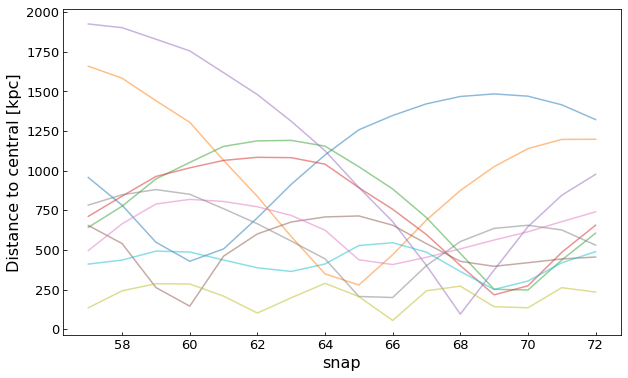

In [14]:
# distance change (in one example)

save_dir = 'sat_catalogs/' if track=='prev' else 'sat_catalogs_later/'
fig, axs = plt.subplots(1, 1, figsize=(10, 6))

snaps=np.arange(57,73,1)
for halo_id in halo_ids_start[2:3]:
    central_id = halos_start[halo_id]['GroupFirstSub']
    survived_sat_ids = np.load(save_dir+str(halo_id)+'_sats.npy')
    if central_id in descendants: 
        for sat_id_snaps in survived_sat_ids[:10]:
            distance_list=[]
            for snap in snaps:
                sat_id_current = sat_id_snaps[snap-snap_start]
                sat = il.groupcat.loadSingle(basePath, snap, subhaloID=sat_id_current)
                descendant_id = descendants[descendants[:,0]==central_id][0][snap-snap_start]
                central = il.groupcat.loadSingle(basePath, snap, subhaloID=descendant_id)
                distance_list.append(distance_list_3d_single(snap, 0.5, sat['SubhaloPos'], central['SubhaloPos']))
            
            plt.plot(snaps,distance_list,alpha=0.5)

plt.xlabel('snap',fontsize=16)
plt.ylabel('Distance to central [kpc]',fontsize=16)
plt.savefig('distance_change_one_halo.png')

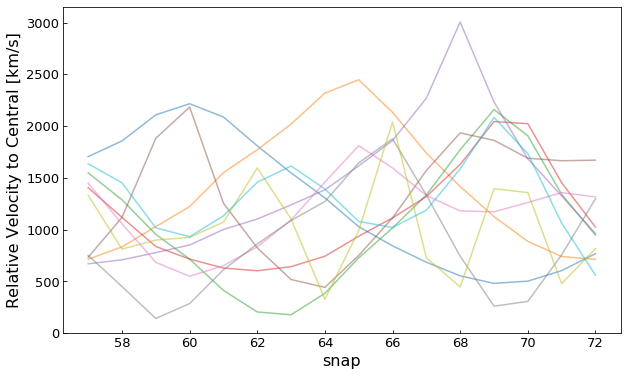

In [17]:
#velocity change (in one example)
save_dir = 'sat_catalogs/' if track=='prev' else 'sat_catalogs_later/'
fig, axs = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(10, 6))

snaps=np.arange(57,73,1)
for halo_id in halo_ids_start[2:3]:
    central_id = halos_start[halo_id]['GroupFirstSub']
    survived_sat_ids = np.load(save_dir+str(halo_id)+'_sats.npy')
    if central_id in descendants: 
        for sat_id_snaps in survived_sat_ids[:10]:
            velocity_list=[]
            for snap in snaps:
                sat_id_current = sat_id_snaps[snap-snap_start]
                sat = il.groupcat.loadSingle(basePath, snap, subhaloID=sat_id_current)
                descendant_id = descendants[descendants[:,0]==central_id][0][snap-snap_start]
                central = il.groupcat.loadSingle(basePath, snap, subhaloID=descendant_id)
                velocity_list.append(np.sqrt(sum(((sat['SubhaloVel']-central['SubhaloVel'])**2))))
            
            plt.plot(snaps,velocity_list,alpha=0.5) 
            
plt.xlabel('snap',fontsize=16)
plt.ylabel('Relative Velocity to Central [km/s]',fontsize=16)
plt.savefig('velocity_change_one_halo.png')

In [30]:
snap_end

76

In [31]:
# the merged satellites
# only work for track == 'later'

total_merged = 0
total_merged_with_central = 0
tng_time = Table.read('TNG_snap_time.csv')
print('number of halos to track:',len(halo_ids_start))

for i in tqdm(range(len(halo_ids_start))):
    halo_id = halo_ids_start[i]
    central_id = halos_start[halo_id]['GroupFirstSub']
    try:
        merged_sat_ids = np.load('sat_catalogs_later/'+str(halo_id)+'_merged_sats.npy')
    except FileNotFoundError:
        continue

    # look into central galaxies' merger tree
    if central_id in descendants:

        central_mdb = il.sublink.loadTree(basePath,snap_start,central_id,fields=['SnapNum','SubfindID'],onlyMDB=True)
        descendant_id = descendants[descendants[:,0]==central_id][0][-1]
        root_descendant_id = central_mdb['SubfindID'][0]
        
        # full merger trees of central decendant
        full_tree_root = il.sublink.loadTree(basePath,99,root_descendant_id,fields=['SnapNum','SubfindID'])
        full_tree      = il.sublink.loadTree(basePath,snap_start+descendants.shape[1]-1,descendant_id,fields=['SnapNum','SubfindID'])
        
        subfind_IDs_root = full_tree_root['SubfindID']
        subfind_IDs = full_tree['SubfindID']
        merged_with_central = []
        merged_with_central_root = []
        merged_sat_ids_cen = []
        merged_sat_ids_cen_root = []
        distance_merged_cen_list = []
        distance_merged_cen_root_list = []
        
        for sat_id in merged_sat_ids:
            # if merged with central before z=0.4 (else: merged with others)
            if sat_id in subfind_IDs_root:
                ind = np.where(full_tree_root['SubfindID']==sat_id)  # look for satellite id in central's root decendant
                
                # if found the satellite subfindID at the correct snapshot
                if len(ind[0])==1 and full_tree_root['SnapNum'][ind[0][0]]==snap_start:
                    diff = 1
                    index = ind[0][0]
                    current_snap = full_tree_root['SnapNum'][index]
                    # track the satellite until it merges
                    while diff<3 and diff>0 and current_snap<snap_end:
                        current_snap = full_tree_root['SnapNum'][index]
                        next_snap = full_tree_root['SnapNum'][index-1]
                        diff= next_snap - current_snap
                        index -= 1
#                     distance_later = distance_list_3d_single(current_snap, tng_time[current_snap]['z'], sat['SubhaloPos'], central['SubhaloPos'])

                    # if merged with central before snap_end
                    if sat_id in subfind_IDs: # merge with central galaxy before snap_end
                        # now current snap is when the satellite last seen in simulation
                        sat_id_current = full_tree_root['SubfindID'][index+1]
                        sat = il.groupcat.loadSingle(basePath, current_snap, subhaloID=sat_id_current)
                        central_id_current = descendants[descendants[:,0]==central_id][0][current_snap-snap_start]
                        central = il.groupcat.loadSingle(basePath, current_snap, subhaloID=central_id_current)
                        merged_sat_ids_cen.append(sat_id)
                        merged_with_central.append(sat_id)  
#                         distance_merged_cen_list.append(distance_later)
                    # merge with central galaxy after snap_end
                    else:                     
                        merged_sat_ids_cen_root.append(sat_id)
                        merged_with_central_root.append(sat_id)
#                         distance_merged_cen_root_list.append(distance_later)
    
        np.save('sat_catalogs_later/'+str(halo_id)+'_merged_with_central_sats.npy',np.array(merged_with_central))
        np.save('sat_catalogs_later/'+str(halo_id)+'_merged_with_central_root_sats.npy',np.array(merged_with_central_root))
        
        # distance for merged_cen sats at earlier time
        distance_list_3d(snap_start, tng_time[snap_start]['z'],
                         subhalos_start[np.in1d(subhalos_start['id'],merged_sat_ids_cen)], subhalos_start[subhalos_start['id']==central_id]['SubhaloPos'][0], 
                         halo_id, merged_sat_ids_cen, save_dir='sat_catalogs_later/',type='_merged_central')
        
        distance_list_3d(snap_start, tng_time[snap_start]['z'],
                         subhalos_start[np.in1d(subhalos_start['id'],merged_sat_ids_cen_root)], subhalos_start[subhalos_start['id']==central_id]['SubhaloPos'][0], 
                         halo_id, merged_sat_ids_cen_root, save_dir='sat_catalogs_later/',type='_merged_central_root')
       
        # distance for merged_cen sats at later time
#         np.save('sat_catalogs_later/distance_'+str(halo_id)+'merged_with_central_sats.npy',np.array(distance_merged_cen_list))
#         np.save('sat_catalogs_later/distance_'+str(halo_id)+'merged_with_central_root_sats.npy',np.array(distance_merged_cen_root_list))
        
        total_merged += len(merged_sat_ids)
        total_merged_with_central += len(merged_with_central)
        
print(total_merged, total_merged_with_central, total_merged_with_central/total_merged)


number of halos to track: 708


100%|██████████| 708/708 [08:37<00:00,  1.37it/s]

2763 1161 0.4201954397394137


In [32]:
# distance distribution (at snap_start) of merged/survived/disrupted satellite galaxies (at snap_last)
bin_number = 20

# id's at snap_start
distances_merged_list = np.array([])
distances_cen_list = np.array([])
distances_survived_list = np.array([])
distances_dpd_list = np.array([])
survived_hm,survived_lm,merged_hm,merged_lm=0,0,0,0

save_dir = 'sat_catalogs_later/'
for halo_id in halo_ids_start:
    central_id = halos_start[halo_id]['GroupFirstSub']
    try:
        survived_sat_ids = np.load(save_dir+str(halo_id)+'_sats.npy')
        survived_sat_ids = survived_sat_ids[:,0].astype(int)
        merged_sat_ids = np.load(save_dir+str(halo_id)+'_merged_sats.npy')
        merged_sat_cen_ids = np.load(save_dir+str(halo_id)+'_merged_with_central_sats.npy')
        merged_sat_cen_root_ids = np.load(save_dir+str(halo_id)+'_merged_with_central_root_sats.npy')
        survived_sat_ids = np.append(survived_sat_ids, merged_sat_cen_root_ids).astype(int)
        
        duplicate_ids = []
        for i,idx in enumerate(merged_sat_ids):
            if (idx in merged_sat_cen_ids) or (idx in merged_sat_cen_root_ids):
                duplicate_ids.append(i)
        merged_sat_ids = np.delete(merged_sat_ids, duplicate_ids)
        
        disrupted_ids = np.load(save_dir+str(halo_id)+'_disrupted_sats.npy')
        
    except FileNotFoundError:
        continue
    
    central_pos = subhalos_start[central_id]['SubhaloPos']   
    
    sat_hm_masscut = 10**(10.2-10)
    mass_show = 'all'
    mass_sats_survived = subhalos_start[np.in1d(subhalos_start['id'],survived_sat_ids)]['SubhaloMassInRadType'][:,4]
    mass_sats_merged_cen = subhalos_start[np.in1d(subhalos_start['id'],merged_sat_cen_ids)]['SubhaloMassInRadType'][:,4]
    mass_sats_merged = subhalos_start[np.in1d(subhalos_start['id'],merged_sat_ids)]['SubhaloMassInRadType'][:,4]
    mass_sats_disrupted = subhalos_start[np.in1d(subhalos_start['id'],disrupted_ids)]['SubhaloMassInRadType'][:,4]
    if  mass_show == 'low_mass':
        survived_sat_ids = survived_sat_ids[mass_sats_survived<sat_hm_masscut*0.704]
        merged_sat_cen_ids = merged_sat_cen_ids[mass_sats_merged_cen<sat_hm_masscut*0.704]
        merged_sat_ids = merged_sat_ids[mass_sats_merged<sat_hm_masscut*0.704]
        disrupted_ids = disrupted_ids[mass_sats_disrupted<sat_hm_masscut*0.704]
    elif mass_show == 'high_mass':
        survived_sat_ids = survived_sat_ids[mass_sats_survived>sat_hm_masscut*0.704]
        merged_sat_cen_ids = merged_sat_cen_ids[mass_sats_merged_cen>sat_hm_masscut*0.704]
        merged_sat_ids = merged_sat_ids[mass_sats_merged>sat_hm_masscut*0.704]
        disrupted_ids = disrupted_ids[mass_sats_disrupted>sat_hm_masscut*0.704]        
    else:
        pass
    
    sats_survived_pos = subhalos_start[survived_sat_ids]['SubhaloPos']
    sats_merged_pos   = subhalos_start[merged_sat_ids]['SubhaloPos']
    sats_cen_pos      = subhalos_start[merged_sat_cen_ids]['SubhaloPos']
    sats_dpd_pos      = subhalos_start[disrupted_ids]['SubhaloPos']
    
    distances_survived = distance_list_3d_lite(snap=snap_start, z=1.0, sat_coords=sats_survived_pos, central_coord_3d=central_pos)
    distances_merged   = distance_list_3d_lite(snap=snap_start, z=1.0, sat_coords=sats_merged_pos, central_coord_3d=central_pos)
    distances_cen      = distance_list_3d_lite(snap=snap_start, z=1.0, sat_coords=sats_cen_pos, central_coord_3d=central_pos)
    distances_dpd      = distance_list_3d_lite(snap=snap_start, z=1.0, sat_coords=sats_dpd_pos, central_coord_3d=central_pos)
    
    distances_survived_list = np.hstack([distances_survived_list,distances_survived])
    distances_merged_list   = np.hstack([distances_merged_list,distances_merged])
    distances_cen_list      = np.hstack([distances_cen_list,distances_cen])
    distances_dpd_list      = np.hstack([distances_dpd_list,distances_dpd])

print(snap_start,track)

IndexError: index 1665941 is out of bounds for axis 0 with size 633753

NameError: name 'distances_survived_list' is not defined

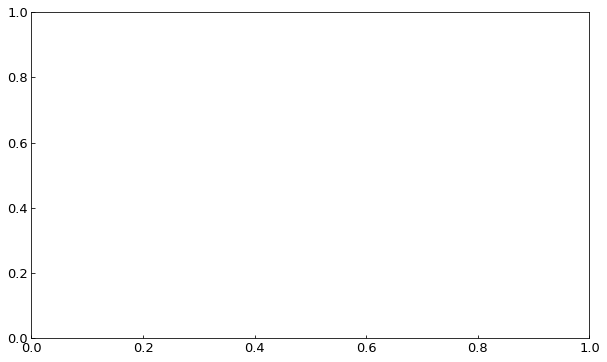

In [10]:
fig, axs = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(10, 6))
plt.hist([distances_survived_list,distances_cen_list,distances_merged_list],
         bins=10 ** np.linspace(1.0, 3.225, num=35),label=['survived','merged_cen','merged_other'],stacked=True)

# plt.annotate(r'low mass $M_{sat}<10.2$',xy=(0.01,0.61),xycoords='axes fraction',fontsize=15)
# plt.annotate(r'high mass $M_{sat}>10.2$',xy=(0.01,0.61),xycoords='axes fraction',fontsize=15)
plt.annotate(r'all mass $M_{sat}>9.5$',xy=(0.01,0.65),xycoords='axes fraction',fontsize=15)

plt.xlabel('r57 [kpc]', fontsize=15)
plt.ylabel('Number of Galaxies', fontsize=15)
plt.xlim([10,10**3.225])
plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize=15)
plt.savefig('Satellites.png',dpi=150)
plt.show()

In [25]:
bins=10 ** np.linspace(1.0, 3.225, num=35)
survived,bin_edges = np.histogram(distances_survived_list,bins=bins)
merged_cen, bin_edges = np.histogram(distances_cen_list,bins=bins)
merged_other, bin_edges = np.histogram(distances_merged_list,bins=bins)
disrupted, bin_edges = np.histogram(distances_dpd_list,bins=bins)
all_sats = survived + merged_other + merged_cen + disrupted

np.save(mass_show+'.npy',(merged_cen)/(all_sats))

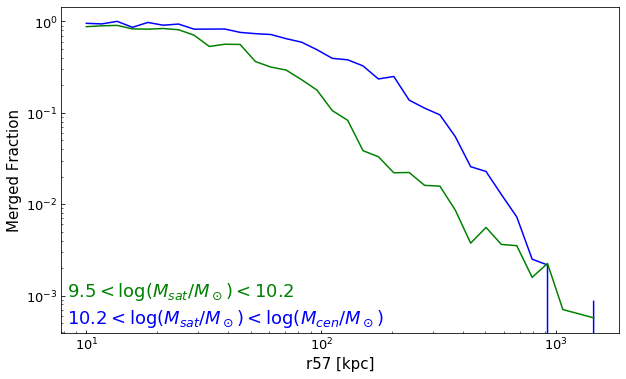

In [26]:
fig, axs = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(10, 6))
merged_fraction_high_mass = np.load('high_mass.npy')
merged_fraction_low_mass = np.load('low_mass.npy')

plt.plot(bin_edges[:-1],merged_fraction_high_mass,color='b')
plt.plot(bin_edges[:-1],merged_fraction_low_mass,color='g')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('r57 [kpc]', fontsize=15)
plt.ylabel('Merged Fraction', fontsize=15)
plt.annotate(r'$9.5<\log(M_{sat}/M_\odot)<10.2$',xy=([0.01,0.11]),xycoords='axes fraction',fontsize=18,color='g')
plt.annotate(r'$10.2<\log(M_{sat}/M_\odot)<\log(M_{cen}/M_\odot)$',xy=([0.01,0.03]),xycoords='axes fraction',fontsize=18,color='b')

plt.savefig('Satellites_merge_fraction.png')

### Distribution evolution plot

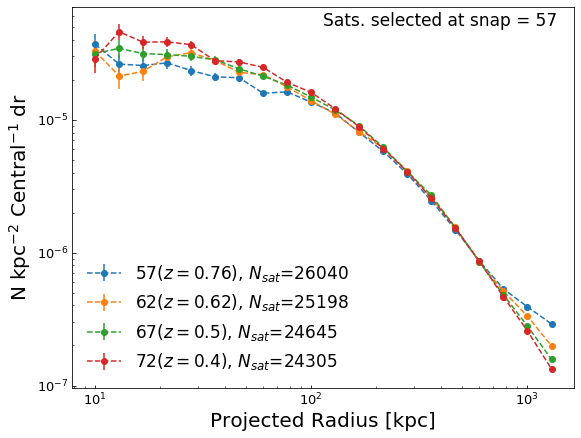

In [36]:
# make the plot
bin_edges=10 ** np.linspace(1.0, 3.225, num=21)

fig, axs = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(9, 7))
tng_time = Table.read('TNG_snap_time.csv')
for i in range(len(radial_z)):
    z = tng_time['z'][snaps[i]]
    plt.errorbar(bin_edges[:-1],radial_z[i]/areas/massive_counts[i],yerr=np.sqrt(radial_z[i])/areas/massive_counts[i],
             fmt='o--',label=str(snaps[i])+'($z=$'+str(z)+'), $N_{sat}$='+str(int(sum(radial_z[i]))))

plt.annotate('Sats. selected at snap = '+str(snap_start),xy=(0.5,0.95),xycoords='axes fraction',fontsize=17)
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Projected Radius [kpc]', fontsize=20)
plt.ylabel('N kpc$^{-2}$ Central$^{-1}$ dr', fontsize=20)
plt.legend(fontsize=17,frameon=False,loc='lower left')
plt.savefig('trace_distribution_'+str(snap_start)+'.png')

satellites within 10.0 to 12.9196277315: 2
satellites within 12.9196277315 to 16.6916780721: 4
satellites within 16.6916780721 to 21.5650266906: 8
satellites within 21.5650266906 to 27.8612116863: 17
satellites within 27.8612116863 to 35.9956483136: 31
satellites within 35.9956483136 to 46.5050376167: 58
satellites within 46.5050376167 to 60.0827773648: 115
satellites within 60.0827773648 to 77.6247116629: 208
satellites within 77.6247116629 to 100.288237745: 369
satellites within 100.288237745 to 129.568669752: 603
satellites within 129.568669752 to 167.397897886: 1061
satellites within 167.397897886 to 216.271852373: 1771
satellites within 216.271852373 to 279.415182146: 2728
satellites within 279.415182146 to 360.994013586: 3936
satellites within 360.994013586 to 466.390826884: 5498
satellites within 466.390826884 to 602.559586074: 7291
snap_start: 57


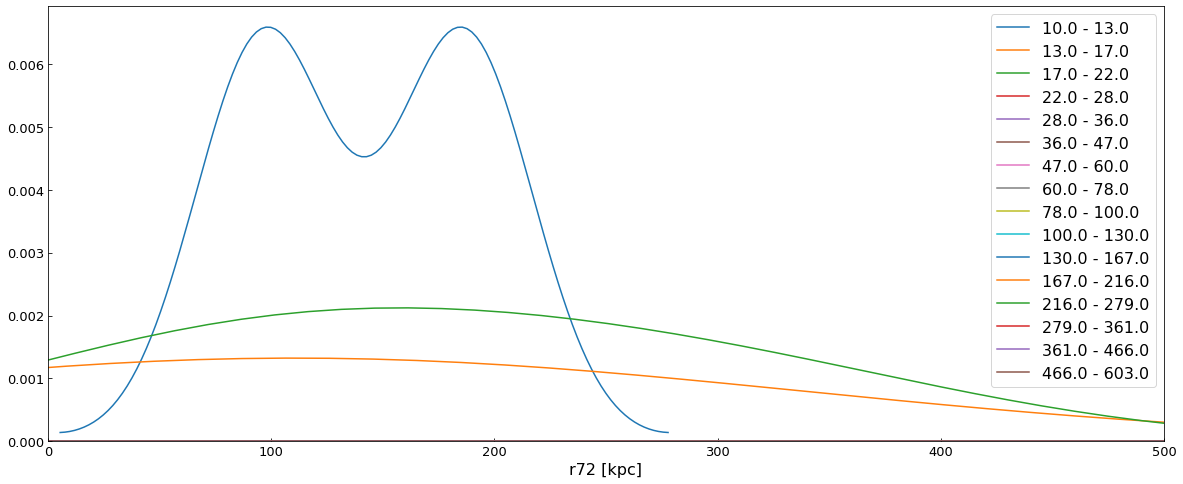

In [12]:
fig, axs = plt.subplots(1, 1, figsize=(20, 8))
fields = ['SubhaloPos','SubhaloMass','SubhaloMassInRadType','SubhaloStellarPhotometricsMassInRad']

subhalos = il.groupcat.loadSubhalos(basePath,snap_start,fields=fields)
del subhalos['count']
subhalos = Table(subhalos)

save_dir = 'sat_catalogs/' if track=='prev' else 'sat_catalogs_later/'
match= 0
no_match = 0
r57_list = np.array([])
r72_list = np.array([])
for halo_id_start in halo_ids_start:
    try:
        r57 = np.load(save_dir+'distance_list_3d_'+str(min(snaps))+'_'+str(halo_id_start)+'.npy')
        r72 = np.load(save_dir+'distance_list_3d_'+str(max(snaps))+'_'+str(halo_id_start)+'.npy')
    except FileNotFoundError:
        continue
    
    if len(r57) == len(r72):
        r57_list = np.append(r57_list,r57)
        r72_list = np.append(r72_list,r72)

# sns.set_palette(sns.color_palette("hls", len(bin_edges[:-5])))
for i in range(len(bin_edges[:-5])):
    areas = np.append(areas, (bin_edges[i + 1] ** 2 - bin_edges[i] ** 2) * np.pi)
    r72_cut = r72_list[np.logical_and(r57_list<bin_edges[i + 1],r57_list<bin_edges[i])]
    print('satellites within '+str(bin_edges[i])+' to '+str(bin_edges[i+1])+':',len(r72_cut))
    sns.kdeplot(r72_cut,label=str(round(bin_edges[i]))+' - '+str(round(bin_edges[i+1])))

plt.legend(fontsize=16,loc='upper right')
plt.xlim([0,500])
plt.xlabel('r72 [kpc]', fontsize=16)
plt.savefig('distance_change_histogram_'+str(snap_start)+'.png',dpi=150)
print('snap_start:',snap_start)

### migration of satellites

In [14]:
r57_list = np.array([])
r72_list = np.array([])
E57_list = np.array([])
E72_list = np.array([])
r57_merged_list = np.array([]) 
rlater_merged_list = np.array([])
mass_list = np.array([])
mass_merged_list = np.array([])
logssfr_list = np.array([])

save_dir = 'sat_catalogs_later/'
print(save_dir)

# load subhalos
fields = ['SubhaloPos','SubhaloMass','SubhaloStellarPhotometricsMassInRad',
          'SubhaloMassInRadType','SubhaloStellarPhotometrics','SubhaloGrNr','SubhaloVel']

subhalos57 = il.groupcat.loadSubhalos(basePath,57,fields=fields)
del subhalos57['count']
subhalos57 = Table(subhalos57)
print('finished loading subhalos57')

subhalos72 = il.groupcat.loadSubhalos(basePath,72,fields=fields)
del subhalos72['count']
subhalos72 = Table(subhalos72)
print('finished loading subhalos72')

fnf=0
for halo_id_start in halo_ids_start:
    try:
        
        # survived satellites
        sat_ids = np.load('sat_catalogs_later/'+str(halo_id_start)+'_sats.npy').astype(int)
        sat_ids_57 = sat_ids[:,0]
        sat_ids_72 = sat_ids[:,72-57]
        central_id_57 = halos_start[halo_id_start]['GroupFirstSub']
        central_id_72 = decendants[decendants[:,0]==central_id_57][0][72-57]
        
        r57 = np.load(save_dir+'distance_list_3d_57_'+str(halo_id_start)+'.npy')  #kpc
        r72 = np.load(save_dir+'distance_list_3d_72_'+str(halo_id_start)+'.npy')  #kpc
        m57 = subhalos57[sat_ids_57]['SubhaloMass']/0.704  # 10^10 m_sun
        m72 = subhalos72[sat_ids_72]['SubhaloMass']/0.704  # 10^10 m_sun
        M57 = subhalos57[central_id_57]['SubhaloMass']/0.704  # 10^10 m_sun
        M72 = subhalos72[central_id_72]['SubhaloMass']/0.704  # 10^10 m_sun
        v57 = np.sqrt(np.sum((subhalos57[sat_ids_57]['SubhaloVel']-subhalos57[central_id_57]['SubhaloVel'])**2,axis=1)) # km/s
        v72 = np.sqrt(np.sum((subhalos72[sat_ids_72]['SubhaloVel']-subhalos72[central_id_72]['SubhaloVel'])**2,axis=1)) # km/s
        
        r57 = r57*3.086  # kpc--m
        r72 = r72*3.086  # kpc--m
        m57 = m57*1.989  # 10^10 m_sun--kg
        m72 = m72*1.989  # 10^10 m_sun--kg
        M57 = M57*1.989e10  # 10^10 m_sun--kg
        M72 = M72*1.989e10  # 10^10 m_sun--kg
        v57 = v57*1000 # km/s--m/s
        v72 = v72*1000 # km/s--m/s
        G=6.67
        E57 = 0.5*m57*v57**2-G*M57*m57/r57
        E72 = 0.5*m72*v72**2-G*M72*m72/r72

        m57_selection = np.log(subhalos57[sat_ids_57]['SubhaloMassInRadType'][:,4]/0.704)+10  # log
        
        # merged satellites
        sat_merged_cen_ids = np.load('sat_catalogs_later/'+str(halo_id_start)+'_merged_with_central_sats.npy').astype(int)
        r57_merged = np.load('sat_catalogs_later/distance_list_merged_central_3d_57_'+str(halo_id_start)+'.npy')
        rlater_merged = np.load('sat_catalogs_later/distance_'+str(halo_id_start)+'merged_with_central_sats.npy')
        m57_merged = np.log(subhalos57[sat_merged_cen_ids]['SubhaloMassInRadType'][:,4]/0.704)+10
        
    except FileNotFoundError:
        fnf +=1

    if len(r57) == len(r72) and len(r57) == len(m57):
        mass_list = np.append(mass_list,m57_selection)
        mass_merged_list = np.append(mass_merged_list,m57_merged)
        r57_list = np.append(r57_list,r57)
        r72_list = np.append(r72_list,r72)
        E57_list = np.append(E57_list,E57)
        E72_list = np.append(E72_list,E72)
        
        # merged satellites
        r57_merged_list = np.append(r57_merged_list,r57_merged)
        rlater_merged_list = np.append(rlater_merged_list,rlater_merged)


sat_catalogs_later/
finished loading subhalos57
finished loading subhalos72


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide


In [69]:
print(E57_list)

[ -2.14973194e+13   4.22184035e+13   1.13406378e+13 ...,   1.36527221e+13
   9.58250537e+12   1.36527221e+13]


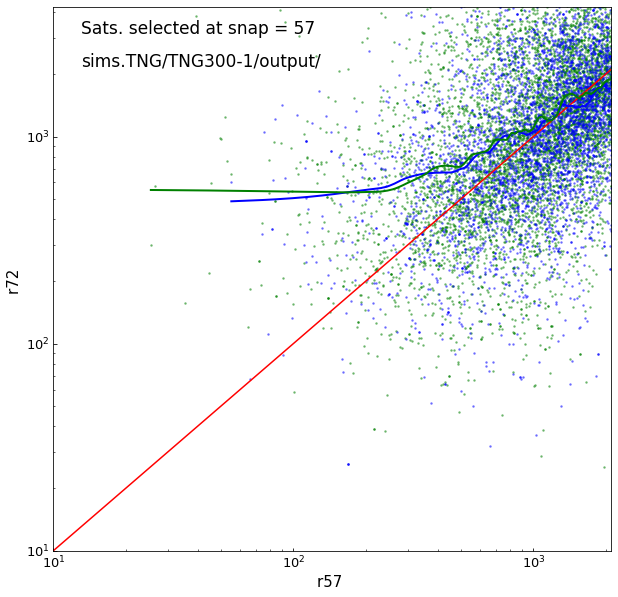

In [76]:
# radius change of satellites
masscut = 10.2
r72_high_mass = r72_list[mass_list>masscut]
r57_high_mass = r57_list[mass_list>masscut]
r72_low_mass = r72_list[mass_list<masscut]
r57_low_mass = r57_list[mass_list<masscut]

fig, axs = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(10, 10))
plt.scatter(r57_low_mass,r72_low_mass,marker='.',c='g',s=10,alpha=0.4,label='low mass (<'+str(masscut)+')')
plt.scatter(r57_high_mass,r72_high_mass,marker='.',c='b',s=10,alpha=0.4,label='high mass (>'+str(masscut)+')')
plt.plot([10,10**3.325],[10,10**3.325],'r')
plt.xlim([10,10**3.325])
plt.ylim([10,10**3.625])
plt.xscale('log')
plt.yscale('log')
plt.annotate('Sats. selected at snap = '+str(snap_start),xy=(0.05,0.95),xycoords='axes fraction',fontsize=17)
plt.annotate(basePath,xy=(0.05,0.89),xycoords='axes fraction',fontsize=17)

# non-parametric fit
nonpar_fit=lowess(r72_high_mass, r57_high_mass,frac=0.05)
plt.plot(nonpar_fit[:,0],nonpar_fit[:,1],'b',linewidth=2)
nonpar_fit=lowess(r72_low_mass, r57_low_mass,frac=0.05)
plt.plot(nonpar_fit[:,0],nonpar_fit[:,1],'g',linewidth=2)


plt.xlabel('r57 ', fontsize=15)
plt.ylabel('r72 ', fontsize=15)
plt.savefig('radius_change_two_snap_'+str(snap_start)+'.png')

(-3, 3)

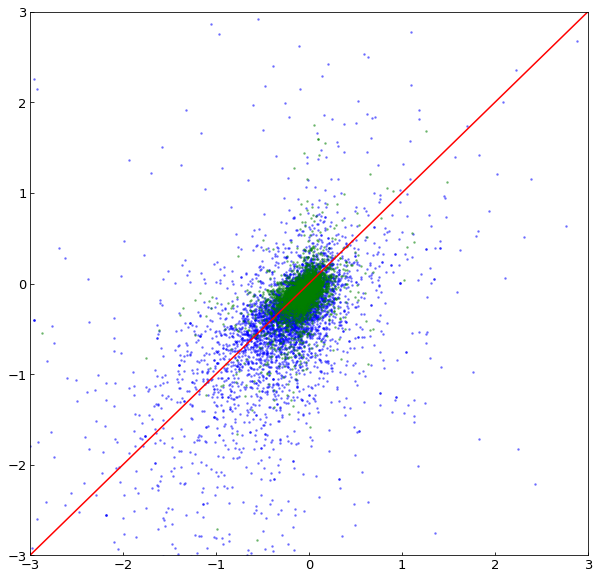

In [17]:
# radius change of satellites
masscut = 10.2
E72_high_mass = E72_list[mass_list>masscut]/1e14
E57_high_mass = E57_list[mass_list>masscut]/1e14
E72_low_mass = E72_list[mass_list<masscut]/1e14
E57_low_mass = E57_list[mass_list<masscut]/1e14

fig, axs = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(10, 10))
plt.scatter(E57_high_mass,E72_high_mass,marker='.',c='b',s=10,alpha=0.4,label='high mass (>'+str(masscut)+')')
plt.scatter(E57_low_mass,E72_low_mass,marker='.',c='g',s=10,alpha=0.4,label='low mass (<'+str(masscut)+')')
plt.plot([-10,10],[-10,10],'r')
plt.xlim([-3,3])
plt.ylim([-3,3])
# plt.xscale('log')
# plt.yscale('log')
# plt.annotate('Sats. selected at snap = '+str(snap_start),xy=(0.05,0.95),xycoords='axes fraction',fontsize=17)
# plt.annotate(basePath,xy=(0.05,0.89),xycoords='axes fraction',fontsize=17)

# # non-parametric fit
# # nonpar_fit=lowess(r72_high_mass, r57_high_mass,frac=0.05)
# # plt.plot(nonpar_fit[:,0],nonpar_fit[:,1],'b',linewidth=2)
# # nonpar_fit=lowess(r72_low_mass, r57_low_mass,frac=0.05)
# # plt.plot(nonpar_fit[:,0],nonpar_fit[:,1],'g',linewidth=2)


# plt.xlabel('r57 ', fontsize=15)
# plt.ylabel('r72 ', fontsize=15)
# plt.savefig('radius_change_two_snap_'+str(snap_start)+'.png')

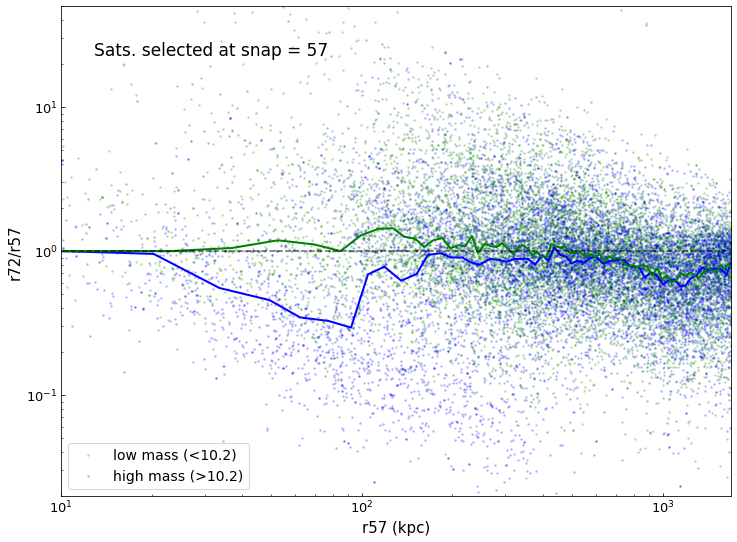

In [41]:
# plotting (mass dependence)

fig, axs = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(12, 9))

# cut sample (high/low mass)
masscut = 10.2
r72_high_mass = r72_list[mass_list>masscut]
r57_high_mass = r57_list[mass_list>masscut]
r72_low_mass = r72_list[mass_list<masscut]
r57_low_mass = r57_list[mass_list<masscut]

# include merged satellites
r72_high_mass = np.append(r72_high_mass,rlater_merged_list[mass_merged_list>masscut])
r57_high_mass = np.append(r57_high_mass,r57_merged_list[mass_merged_list>masscut])
r72_low_mass = np.append(r72_low_mass,rlater_merged_list[mass_merged_list<masscut])
r57_low_mass = np.append(r57_low_mass,r57_merged_list[mass_merged_list<masscut])

# plot
plt.scatter(r57_low_mass,r72_low_mass/r57_low_mass,marker='.',c='g',s=10,alpha=0.2,label='low mass (<'+str(masscut)+')')
plt.scatter(r57_high_mass,r72_high_mass/r57_high_mass,marker='.',c='b',s=10,alpha=0.2,label='high mass (>'+str(masscut)+')')


# running median
group_size = 160
low_mass_ratio_median_list = []
high_mass_ratio_median_list = []
low_mass_r57_median_list = []
high_mass_r57_median_list = []
ratio_low_mass = r72_low_mass/r57_low_mass
ratio_high_mass = r72_high_mass/r57_high_mass

index=0
arr1inds = r57_low_mass.argsort()
ratio_low_mass = ratio_low_mass[arr1inds[::-1]]
r57_low_mass = r57_low_mass[arr1inds[::-1]]
while index<len(r57_low_mass):
    
    low_mass_ratio_slice = ratio_low_mass[index: index + group_size - 1]
    low_mass_r57_slice = r57_low_mass[index: index + group_size - 1]
    low_mass_ratio_median = np.median(low_mass_ratio_slice)
    low_mass_r57_median = np.median(low_mass_r57_slice)
    
    low_mass_ratio_median_list.append(low_mass_ratio_median)
    low_mass_r57_median_list.append(low_mass_r57_median)
    index = index + group_size

index=0
arr1inds = r57_high_mass.argsort()
ratio_high_mass = ratio_high_mass[arr1inds[::-1]]
r57_high_mass = r57_high_mass[arr1inds[::-1]]
while index<len(r57_high_mass):
    high_mass_ratio_slice = ratio_high_mass[index: index + group_size - 1]
    high_mass_r57_slice = r57_high_mass[index: index + group_size - 1]
    high_mass_ratio_median = np.median(high_mass_ratio_slice)
    high_mass_r57_median = np.median(high_mass_r57_slice)
    
    high_mass_ratio_median_list.append(high_mass_ratio_median)
    high_mass_r57_median_list.append(high_mass_r57_median)
    index = index + group_size

plt.plot(high_mass_r57_median_list,high_mass_ratio_median_list,'b',linewidth=2)
plt.plot(low_mass_r57_median_list,low_mass_ratio_median_list,'g',linewidth=2)


# non-parametric fit
# nonpar_fit=lowess(r72_high_mass/r57_high_mass, r57_high_mass,frac=0.1)
# plt.plot(nonpar_fit[:,0],nonpar_fit[:,1],'b',linewidth=2)
# nonpar_fit=lowess(r72_low_mass/r57_low_mass, r57_low_mass,frac=0.1)
# plt.plot(nonpar_fit[:,0],nonpar_fit[:,1],'g',linewidth=2)

plt.plot([0,10000],[1,1],'--k',alpha=0.6)
plt.xscale('log')
plt.yscale('log')
plt.xlim([10,10**3.225])
plt.ylim([0.02,50])
plt.legend(fontsize=14) 
plt.annotate('Sats. selected at snap = '+str(snap_start),xy=(0.05,0.9),xycoords='axes fraction',fontsize=17)
plt.xlabel('r57 (kpc)', fontsize=15)
plt.ylabel('r72/r57', fontsize=15)
plt.savefig('distance_ratio_change_two_snap_'+str(snap_start)+'.png',dpi=150)


### mass change of satellite galaxies

In [18]:
# half mass radius definition: ['SubhaloMassInRadType'][4]
# surface magnitude definition: ['SubhaloStellarPhotometricsMassInRad']

fields = ['SubhaloPos','SubhaloMass','SubhaloStellarPhotometricsMassInRad']
save_dir = 'sat_catalogs/' if track=='prev' else 'sat_catalogs_later/'

m72_stellar = []
m57_stellar = []
m72_subhalo = []
m57_subhalo = []
logssfr_list = []
if track == 'prev':
    halos_ids_start = np.copy(halo_ids_start)
else:
    halos_ids_start = np.copy(halo_ids_start_checked)
    
for halo_id_start in halos_ids_start:
    sat_ids = np.load(save_dir+str(halo_id_start)+'_sats.npy')
    sat_ids_start = sat_ids[:,0]
    logssfr_start = np.load(save_dir+str(halo_id_start)+'_logssfr_sats.npy')
    sat_cat = subhalos_start[sat_ids_start.astype(int)]
    
    for i,sat_id_start in enumerate(sat_ids_start):
        logssfr_list.append(logssfr_start[i])
        if track=='prev':
            tree = il.sublink.loadTree(basePath,snap_start,sat_id_start,
                               fields=['SnapNum','SubfindID','SubhaloMass','SubhaloStellarPhotometricsMassInRad','SubhaloMassInRadType'],
                               onlyMPB=True)
            
            m72_subhalo.append(tree['SubhaloMass'][0])
            m57_subhalo.append(tree['SubhaloMass'][snap_end-snap_start])
            m72_stellar.append(tree['SubhaloMassInRadType'][4][0])
            m57_stellar.append(tree['SubhaloMassInRadType'][4][snap_end-snap_start])
                
        else:
            snap_end =snaps[-1] #72 
            tree = il.sublink.loadTree(basePath,snap_start,sat_id_start,
                               fields=['SnapNum','SubfindID','SubhaloMass','SubhaloStellarPhotometricsMassInRad','SubhaloMassInRadType'],
                               onlyMDB=True)
            m72_subhalo.append(tree['SubhaloMass'][-(snap_end-snap_start)])
            m57_subhalo.append(subhalos_start[int(sat_id_start)]['SubhaloMass'])
        
            
            m72_stellar.append(tree['SubhaloMassInRadType'][:,4][-(snap_end-snap_start)])
            m57_stellar.append(subhalos_start[int(sat_id_start)]['SubhaloMassInRadType'][4])


m72_stellar = np.array(m72_stellar)
m57_stellar = np.array(m57_stellar)
m72_subhalo = np.array(m72_subhalo)
m57_subhalo = np.array(m57_subhalo)     


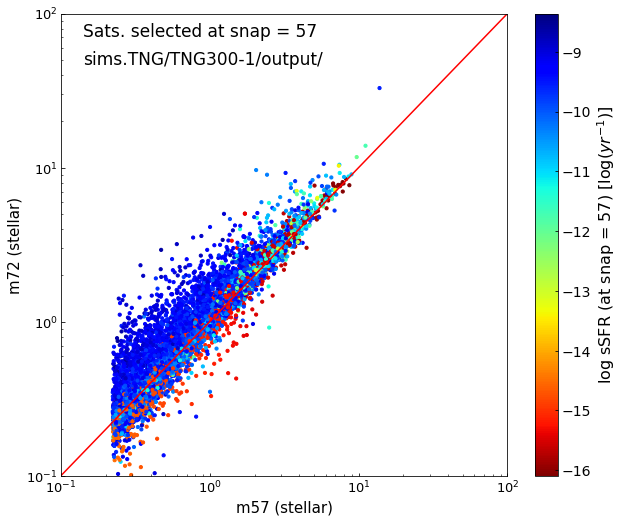

In [43]:
# stellar mass change of satellites

fig, axs = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(10, 8.5))
plt.scatter(m57_stellar,m72_stellar,c=np.array(logssfr_list),s=10,cmap='jet_r')

plt.plot([0.1,1e2],[0.1,1e2],'r')
plt.xlim([0.1,1e2])
plt.ylim([0.1,1e2])
plt.xscale('log')
plt.yscale('log')
plt.annotate('Sats. selected at snap = '+str(snap_start),xy=(0.05,0.95),xycoords='axes fraction',fontsize=17)
plt.annotate(basePath,xy=(0.05,0.89),xycoords='axes fraction',fontsize=17)

cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14) 
cbar.set_label(r'log sSFR (at snap = '+str(snap_start)+') [$\log(yr^{-1})$]',size=16)

plt.xlabel('m57 (stellar)', fontsize=15)
plt.ylabel('m72 (stellar)', fontsize=15)
plt.savefig('mass_change_two_snap_'+str(snap_start)+'.png')

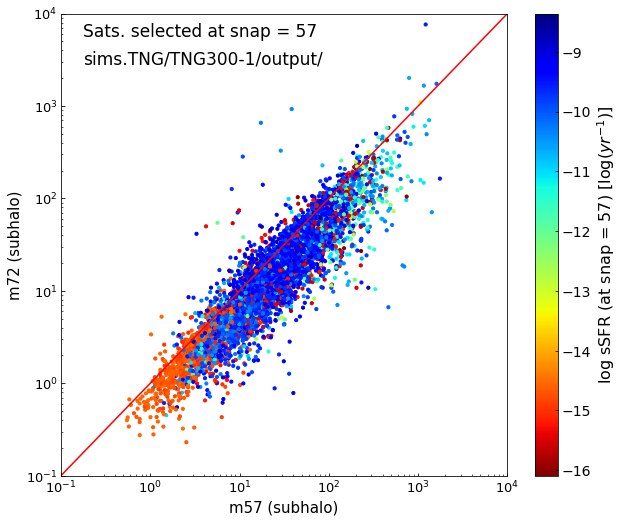

In [44]:
# subhalo mass change of satellites

fig, axs = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(10, 8.5))

plt.scatter(m57_subhalo,m72_subhalo,c=np.array(logssfr_list),s=10,cmap='jet_r')

plt.plot([0.1,1e4],[0.1,1e4],'r')
plt.xlim([0.1,1e4])
plt.ylim([0.1,1e4])
plt.xscale('log')
plt.yscale('log')
plt.annotate('Sats. selected at snap = '+str(snap_start),xy=(0.05,0.95),xycoords='axes fraction',fontsize=17)
plt.annotate(basePath,xy=(0.05,0.89),xycoords='axes fraction',fontsize=17)

cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14) 
cbar.set_label(r'log sSFR (at snap = '+str(snap_start)+') [$\log(yr^{-1})$]',size=16)

plt.xlabel('m57 (subhalo)', fontsize=15)
plt.ylabel('m72 (subhalo)', fontsize=15)
plt.savefig('mass_subhalo_change_two_snap_'+str(snap_start)+'.png')

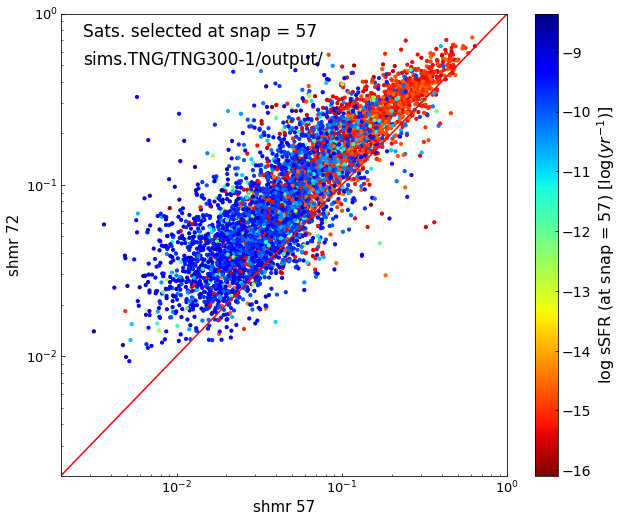

In [66]:
# shmr change of satellites

fig, axs = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(10, 8.5))

plt.scatter(np.array(m57_stellar)/np.array(m57_subhalo),np.array(m72_stellar)/np.array(m72_subhalo)
            ,c=np.array(logssfr_list),s=10,cmap='jet_r')

plt.plot([0.002,1],[0.002,1],'r')
plt.xlim([0.002,1])
plt.ylim([0.002,1])
plt.xscale('log')
plt.yscale('log')
plt.annotate('Sats. selected at snap = '+str(snap_start),xy=(0.05,0.95),xycoords='axes fraction',fontsize=17)
plt.annotate(basePath,xy=(0.05,0.89),xycoords='axes fraction',fontsize=17)

cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14) 
cbar.set_label(r'log sSFR (at snap = '+str(snap_start)+') [$\log(yr^{-1})$]',size=16)

plt.xlabel('shmr 57', fontsize=15)
plt.ylabel('shmr 72', fontsize=15)
plt.savefig('shmr_change_two_snap_'+str(snap_start)+'.png')


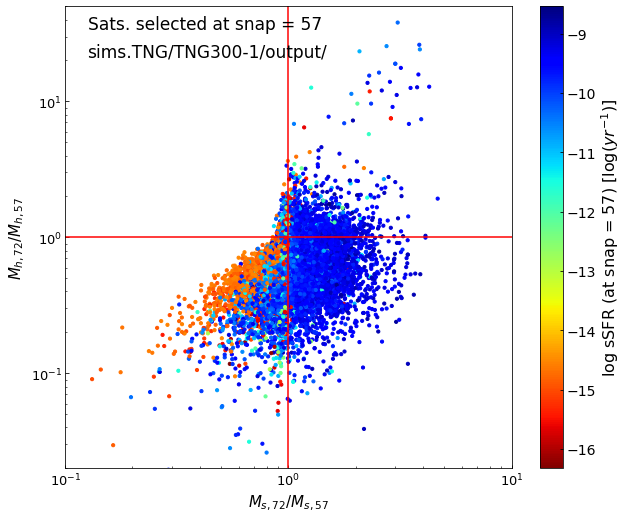

In [19]:
# shmr change of satellites

fig, axs = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(10, 8.5))

plt.scatter(np.array(m72_stellar)/np.array(m57_stellar),np.array(m72_subhalo)/np.array(m57_subhalo)
            ,c=np.array(logssfr_list),s=10,cmap='jet_r')

plt.plot([0,100],[1,1],'r')
plt.plot([1,1],[0,100],'r')
plt.xlim([0.1,10])
plt.ylim([0.02,50])
plt.xscale('log')
plt.yscale('log')
plt.annotate('Sats. selected at snap = '+str(snap_start),xy=(0.05,0.95),xycoords='axes fraction',fontsize=17)
plt.annotate(basePath,xy=(0.05,0.89),xycoords='axes fraction',fontsize=17)

cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14) 
cbar.set_label(r'log sSFR (at snap = '+str(snap_start)+') [$\log(yr^{-1})$]',size=16)

plt.xlabel(r'$M_{s,72}/M_{s,57}$', fontsize=15)
plt.ylabel(r'$M_{h,72}/M_{h,57}$', fontsize=15)
plt.savefig('shmr_change_two_snap_'+str(snap_start)+'.png')

In [11]:
save_dir = 'sat_catalogs/' if track=='prev' else 'sat_catalogs_later/'
if track == 'prev':
    halo_ids_start = np.copy(halo_ids_start)
    tree_length = snap_start+1
    onlymdb = False
    onlympb = True
else:
    halo_ids_start = np.copy(halo_ids_start_checked)
    tree_length = 99 - snap_start 
    onlymdb = True
    onlympb = False

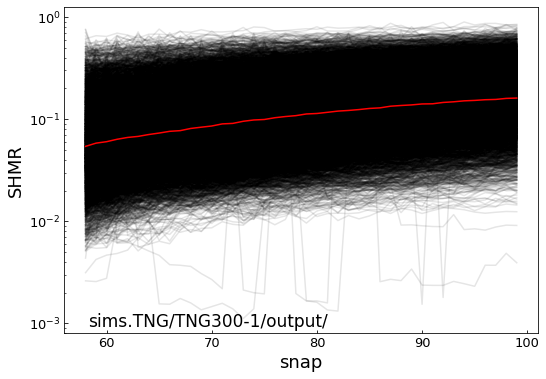

In [74]:
# shmr change as a function of redshift

fig, axs = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(8.5, 6))

m_subhalo = np.array(np.ones(tree_length))
m_stellar = np.array(np.ones(tree_length))
for halo_id_start in halo_ids_start:
    sat_ids = np.load(save_dir+str(halo_id_start)+'_sats.npy')
    sat_ids_start = sat_ids[:,0]
    sat_cat = subhalos[sat_ids_start.astype(int)]
    
    for sat_id in sat_ids_start:
        tree = il.sublink.loadTree(basePath,snap_start,sat_id,
                               fields=['SnapNum','SubfindID','SubhaloMass','SubhaloStellarPhotometricsMassInRad'],
                               onlyMDB=onlymdb,onlyMPB=onlympb)
        if tree == None:  
            continue
        
        if len(tree['SubhaloMass'])==tree_length:
            snaps = tree['SnapNum'][:tree_length]
            m_subhalo = np.vstack([m_subhalo,  np.array(tree['SubhaloMass'][:tree_length])])
            m_stellar = np.vstack([m_stellar, np.array(tree['SubhaloStellarPhotometricsMassInRad'][:tree_length])])
        
            plt.plot(tree['SnapNum'][:tree_length],
                     tree['SubhaloStellarPhotometricsMassInRad'][:tree_length]/tree['SubhaloMass'][:tree_length],
                     'k',alpha=0.1)
    
m_subhalo = np.array(m_subhalo)
m_stellar = np.array(m_stellar)
plt.plot(snaps,np.median(m_stellar,axis=0)/np.median(m_subhalo,axis=0),'r')
plt.annotate(basePath,xy=(0.05,0.02),xycoords='axes fraction',fontsize=17)

plt.xlabel('snap',fontsize=18)
plt.ylabel('SHMR',fontsize=18)
plt.yscale('log')
plt.savefig('shmr_change_snaps_'+str(snap_start)+'.png')


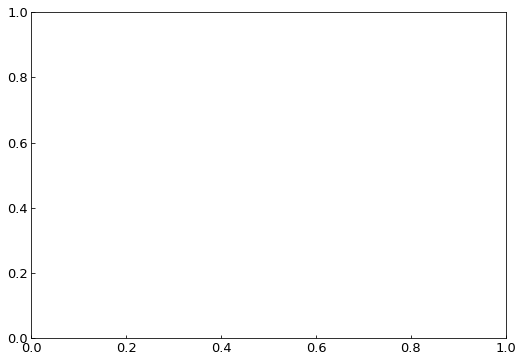

In [37]:
# radius change as a function of redshift

fig, axs = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(8.5, 6))

r_subhalo = np.array(np.ones(tree_length))
for halo_id_start in halo_ids_start[:10]:
    sat_ids = np.load(save_dir+str(halo_id_start)+'_sats.npy')
    sat_ids_start = sat_ids[:,0]
    sat_cat = subhalos[sat_ids_start.astype(int)]
    halo = halos_start[halo_id]
    
    for sat_id in sat_ids_start:
        tree = il.sublink.loadTree(basePath,snap_start,sat_id,
                               fields=['SnapNum','SubfindID','SubhaloPos'],
                               onlyMDB=onlymdb,onlyMPB=onlympb)
        if tree == None:  
            continue
        
        if len(tree['SubhaloMass'])==tree_length:
            snaps = tree['SnapNum'][:tree_length]
            r_subhalo = np.vstack([m_subhalo,  np.array(tree['SubhaloMass'][:tree_length])])
        
            plt.plot(tree['SnapNum'][:tree_length],
                     tree['SubhaloStellarPhotometricsMassInRad'][:tree_length]/tree['SubhaloMass'][:tree_length],
                     'k',alpha=0.1)
    
m_subhalo = np.array(m_subhalo)
plt.annotate(basePath,xy=(0.05,0.02),xycoords='axes fraction',fontsize=17)

plt.xlabel('snap',fontsize=18)
plt.ylabel('SHMR',fontsize=18)
plt.yscale('log')
plt.savefig('r_change_snaps_'+str(snap_start)+'.png')

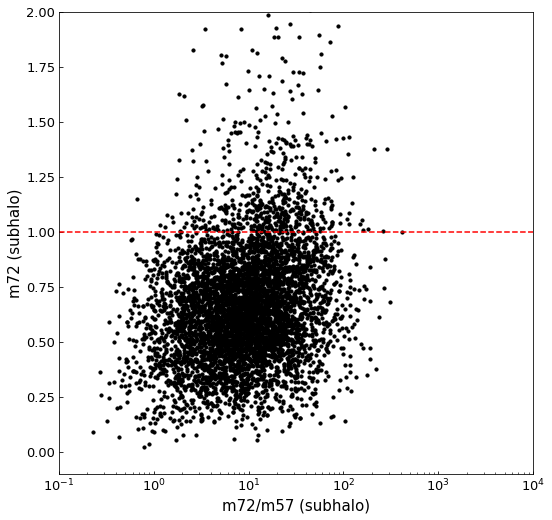

In [67]:
# subhalo mass change of satellites
fig, axs = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(8.5, 8.5))
plt.scatter(m72_subhalo,np.array(m72_subhalo)/np.array(m57_subhalo),c='k',s=10)

plt.plot([0.1,1e4],[1,1],'--r')
plt.xlim([0.1,1e4])
plt.ylim([-0.1,2])
plt.xscale('log')
# plt.yscale('log')

plt.xlabel('m72/m57 (subhalo)', fontsize=15)
plt.ylabel('m72 (subhalo)', fontsize=15)
plt.savefig('mass_subhalo_ratio_change_two_snap.png')

### Halo Mass of centrals

11.0001


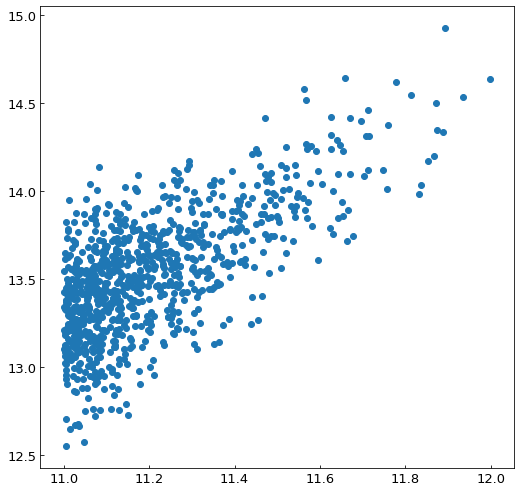

In [18]:
fig, axs = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(8.5, 8.5))
mh = np.log10(halos_start[halo_ids_start]['Group_M_Crit200']/0.704)+10
ms = np.log10(subhalos_start[central_ids_start]['SubhaloStellarPhotometricsMassInRad']/0.704)+10
print(min(ms))
np.save('ms_mh_central.npy',np.asarray([ms,mh]))
plt.scatter(ms,mh)

### mass growth of central galaxies

In [14]:
print(track)
snaps = np.arange(snap_start,snap_start-19,-5) if track =='prev' else np.arange(snap_start,snap_start+19,5)
if track == 'prev':
    onlymdb = False
    onlympb = True
else:
    onlymdb = True
    onlympb = False

later


57 later
Number of centrals tracked: 886


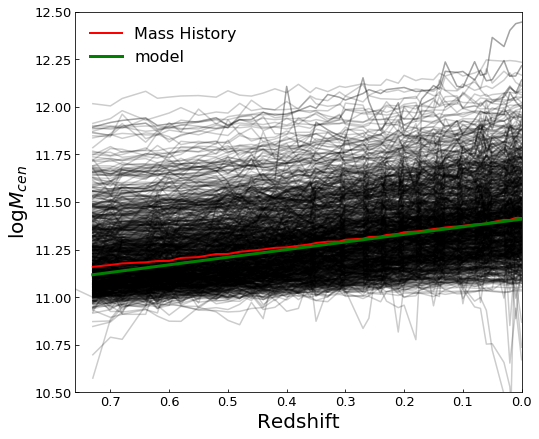

In [17]:
fig, axs = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(8, 7))
tree_length=99-snap_start
print(snap_start,track)

tng_time = Table.read('TNG_snap_time.csv')
mass_list = np.array(np.ones(tree_length))
mass_sf_list = np.array(np.ones(tree_length))
mass_ratio_list = np.array(np.ones(tree_length))
for central_id_start in central_ids_start:
    tree = il.sublink.loadTree(basePath,snap_start,central_id_start,
                             fields=['SnapNum','SubfindID','SubhaloMass','SubhaloStellarPhotometricsMassInRad','SubhaloSFR'],
                             onlyMPB=onlympb, onlyMDB=onlymdb)
    
    # snapNum vs. Stellar Mass  (mass growth recorded by simulation)
    snaps_tree = tree['SnapNum'][:tree_length]
    zs = tng_time['z'][snaps_tree]
    if len(snaps_tree)<tree_length: continue
        
    mass_growth_record = np.array(tree['SubhaloStellarPhotometricsMassInRad'][:tree_length])/0.704
    mass_list = np.vstack([mass_list,mass_growth_record])
    plt.plot(zs, np.log10(mass_growth_record)+10,'k',alpha=0.2)
    
# #     predict mass growth from SFR
#     mass_sf = [mass_growth_record[tree_length-1]]
#     mass_ratio = mass_growth_record/mass_sf 
#     for snap in snaps[:-1]:
#         mass_sf.append(mass_sf[-1]+0.1*tree['SubhaloSFR'][np.where(snaps==snap)[0][0]]*
#                        (tng_time['age'][snap]-tng_time['age'][snap-1]))
#     try:
#         mass_sf_list = np.vstack([mass_sf_list,np.array(mass_sf)])
#         mass_ratio_list = np.vstack([mass_ratio_list,mass_ratio])
#     except ValueError:
#         continue

mass_list = np.log10(mass_list[1:])+10
mass_sf_list = np.log10(mass_sf_list[1:])+10
mass_ratio_list = np.log10(mass_ratio_list[1:])+10
print('Number of centrals tracked:',len(mass_list))

# plot median trend
plt.plot(zs,np.median(mass_list,axis=0),color='r',linewidth=2,label='Mass History')
# plt.plot(np.flip(zs,axis=0),np.median(mass_sf_list,axis=0),color='b',linewidth=2,label='estimate from SF')

# model
zs_model = np.linspace(0,0.73,100)
ms_cen_model = 11.41-0.4*zs_model
plt.plot(zs_model,ms_cen_model,'g',label='model',linewidth=3)

plt.xlabel('Redshift', fontsize=20)
plt.ylabel(r'$\log M_{cen}$', fontsize=20)
plt.ylim([10.5,12.5])
plt.xlim([0,tng_time['z'][snap_start]])
plt.gca().invert_xaxis()
plt.legend(fontsize=16,frameon=False)
plt.savefig('stellar_mass_growth_central.png')

In [ ]:
fig, axs = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(8, 7))
tree_length=99-snap_start

tng_time = Table.read('TNG_snap_time.csv')
mass_list = np.array(np.ones(tree_length))
print(snap_start,track)

for central_id_start in central_ids_start:
    tree = il.sublink.loadTree(basePath,snap_start,central_id_start,
                             fields=['SnapNum','SubfindID','SubhaloMass','SubhaloGrNr'],
                             onlyMPB=onlympb, onlyMDB=onlymdb)
    
    # snapNum vs. Stellar Mass  (mass growth recorded by simulation)
    snaps_tree = tree['SnapNum'][:tree_length]
    zs = tng_time['z'][snaps_tree]
    if len(snaps_tree)<tree_length: continue
    
    halo_mass_growth_record = []
    halo_ids_record = tree['SubhaloGrNr'][:tree_length]
    for i,snap in enumerate(snaps_tree):
        halo_record = il.groupcat.loadSingle(basePath, snap, haloID=halo_ids_record[i])
        halo_mass_growth_record.append(halo_record['GroupMass'])
        
#     mass_growth_record = np.array(tree['SubhaloMass'][:tree_length])/0.704
    mass_growth_record = np.array(halo_mass_growth_record)/0.704
    mass_list = np.vstack([mass_list,mass_growth_record])

    plt.plot(zs, np.log10(mass_growth_record)+10,'k',alpha=0.2)

mass_list = np.log10(mass_list[1:])+10
print('Number of centrals tracked:',len(mass_list))

# plot median trend
plt.plot(zs,np.median(mass_list,axis=0),color='r',linewidth=2,label='Mass History')
plt.xlabel('Redshift', fontsize=20)
plt.ylabel(r'$\log M_{cen}$', fontsize=20)
plt.ylim([12.5,16])
plt.xlim([0,tng_time['z'][snap_start]])
plt.gca().invert_xaxis()
plt.legend(fontsize=18,frameon=False)
plt.savefig('subhalo_mass_growth_central.png')

In [ ]:
plt.plot(tree['SnapNum'][:50],np.median(mass_ratio_list,axis=0),color='r',linewidth=2,label='$M_{SFR}/M_{stellar}$')

plt.xlabel('snap', fontsize=20)
plt.ylabel('M_central', fontsize=20)
plt.yscale('log')
plt.xlim([22.5,72])
plt.legend(fontsize=18,frameon=False)
plt.savefig('mass_growth_central.png')